In [1]:
import torch
import numpy as np
from sklearn import metrics
from sklearn.isotonic import IsotonicRegression

import matplotlib.pyplot as plt

# Local imports
import carl_utils.preprocessing as carl_ppro
import carl_utils.models as carl_models
import carl_utils.eval as carl_eval
import carl_utils.plotting as carl_plot

import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = 'cpu'
print(DEVICE)

cuda:0


# Evaluate the effectiveness of this model on test data

## Load the best model

In [21]:
model_name = "models/deepsets_agc_model_jets" #"deepsets_model"

model = carl_models.load_model("{}.zip".format(model_name)).to(DEVICE)
X_scalers, weight_norm = carl_ppro.load_scaling("{}.zip".format(model_name))
features = model.features

print(model), print(model.features);

DeepSetsEnsemble(
  (phi0):  Sequential(
    (0): Conv1d(5, 512, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    (5): ReLU()
  )
  (mlp):  Sequential(
    (0): Linear(in_features=128, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
OrderedDict([('Jet_set', {'set': True, 'size': 5, 'subfeatures': ['Jet_pt', 'Jet_eta', 'Jet_phi', 'Jet_mass', 'Jet_btagCSVV2']})])


## Prepare the test data

In [3]:
n_val_events = int(2e5) // 2
n_test_events = int(2e5)

batch_size = 1024

calibration_nominal_dataset = carl_ppro.DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_nominal_DeepSets_validation_data_new2.root",], features, 0, start_event=n_val_events, stop_event=2*n_val_events)
test_nominal_dataset = carl_ppro.DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_nominal_DeepSets_testing_data_new2.root",], features, 0, stop_event=n_test_events)

calibration_PS_var_dataset = carl_ppro.DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_PS_var_DeepSets_validation_data_new2.root",], features, 1, start_event=n_val_events, stop_event=2*n_val_events)
test_PS_var_dataset = carl_ppro.DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_PS_var_DeepSets_testing_data_new2.root",], features, 1, stop_event=n_test_events)

calibration_generator_data = carl_ppro.CombinedDataset(calibration_nominal_dataset, calibration_PS_var_dataset)
test_generator_data = carl_ppro.CombinedDataset(test_nominal_dataset, test_PS_var_dataset)

100%|██████████| 200000/200000 [00:45<00:00, 4442.72it/s]


In [4]:
calibration_loader = carl_ppro.get_training_DataLoader(calibration_generator_data, features, X_scalers, weight_norm=weight_norm, batch_size=batch_size)
test_loader = carl_ppro.get_training_DataLoader(test_generator_data, features, X_scalers, weight_norm=weight_norm, batch_size=batch_size, shuffle=False)
test_nominal_loader = carl_ppro.get_training_DataLoader(carl_ppro.CombinedDataset(test_nominal_dataset), features, X_scalers, weight_norm=weight_norm, batch_size=batch_size, shuffle=False)

## Get the scores (model output) on the test data

In [22]:
test_scores, test_targets, test_weights = carl_eval.get_scores(
    model,
    test_loader,
    device=DEVICE,
    leave=True
)

100%|██████████| 391/391 [00:12<00:00, 30.68it/s]


## Evaluate the ROC curve for the model

In [23]:
print("Area under the ROC curve: {:.4}".format(metrics.roc_auc_score(test_targets, test_scores, sample_weight=test_weights)))

Area under the ROC curve: 0.5945


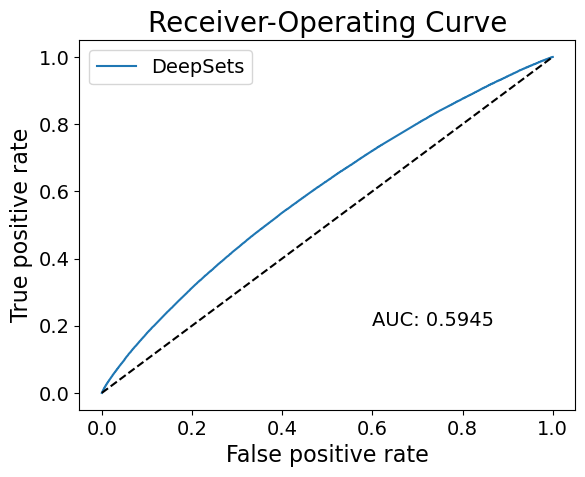

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(test_targets, test_scores, pos_label=1, sample_weight=test_weights)

plt.plot(fpr, tpr, label="DeepSets")
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), '--', c="black")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver-Operating Curve")
plt.legend()
plt.text(0.6, 0.2, "AUC: {:.4}".format(metrics.roc_auc_score(test_targets, test_scores, sample_weight=test_weights)));

## Calibrate the model

In [31]:
iso = IsotonicRegression()
iso.fit(*carl_eval.get_scores(
    model,
    calibration_loader,
    device=DEVICE,
    leave=True
))

100%|██████████| 196/196 [00:18<00:00, 10.50it/s]


IsotonicRegression()

## Get the CARL weights

In [25]:
r_hats = carl_eval.get_r_hats(
            model,
            test_nominal_loader,
            device=DEVICE,
            leave=True
)

100%|██████████| 196/196 [00:05<00:00, 36.10it/s]


## Try calibrated weights also

In [33]:
calibrated_r_hats = carl_eval.get_calibrated_r_hats(
            model,
            iso.predict,
            test_nominal_loader,
            device=DEVICE,
            leave=True
)

100%|██████████| 196/196 [00:21<00:00,  9.04it/s]


# Plot the reweighted distributions

In [26]:
test_nominal_generator_data = carl_ppro.CombinedDataset(test_nominal_dataset)
test_PS_var_generator_data = carl_ppro.CombinedDataset(test_PS_var_dataset)

### Plot jet features

100%|██████████| 1563/1563 [00:05<00:00, 283.80it/s]


199999
200000


/home/mdrnevich/AGC/carl-for-agc/carl_utils/plotting.py:193: RuntimeWarning: invalid value encountered in divide
  x1_ratio = x0_hist/x1_hist
/home/mdrnevich/AGC/carl-for-agc/carl_utils/plotting.py:198: RuntimeWarning: invalid value encountered in divide
  carl_ratio = carl_hist/x1_hist
/home/mdrnevich/AGC/carl-for-agc/carl_utils/plotting.py:235: RuntimeWarning: invalid value encountered in divide
  binsqrsum_x0 = binsqrsum_x0/w0[mask0].sum()
/home/mdrnevich/AGC/carl-for-agc/carl_utils/plotting.py:239: RuntimeWarning: invalid value encountered in divide
  binsqrsum_x1 = binsqrsum_x1/w1[mask1].sum()
100%|██████████| 1563/1563 [00:05<00:00, 305.04it/s]


199982
199993


/home/mdrnevich/AGC/carl-for-agc/carl_utils/plotting.py:193: RuntimeWarning: divide by zero encountered in divide
  x1_ratio = x0_hist/x1_hist
/home/mdrnevich/AGC/carl-for-agc/carl_utils/plotting.py:198: RuntimeWarning: divide by zero encountered in divide
  carl_ratio = carl_hist/x1_hist
100%|██████████| 1563/1563 [00:05<00:00, 282.12it/s]


199760
199833


100%|██████████| 1563/1563 [00:07<00:00, 208.66it/s]


197917
198498


100%|██████████| 1563/1563 [00:09<00:00, 167.47it/s]


190027
192492


100%|██████████| 1563/1563 [00:18<00:00, 85.60it/s]


170290
176687


100%|██████████| 1563/1563 [00:34<00:00, 45.50it/s]


138637
149370


100%|██████████| 1563/1563 [00:52<00:00, 29.60it/s]


101995
114905


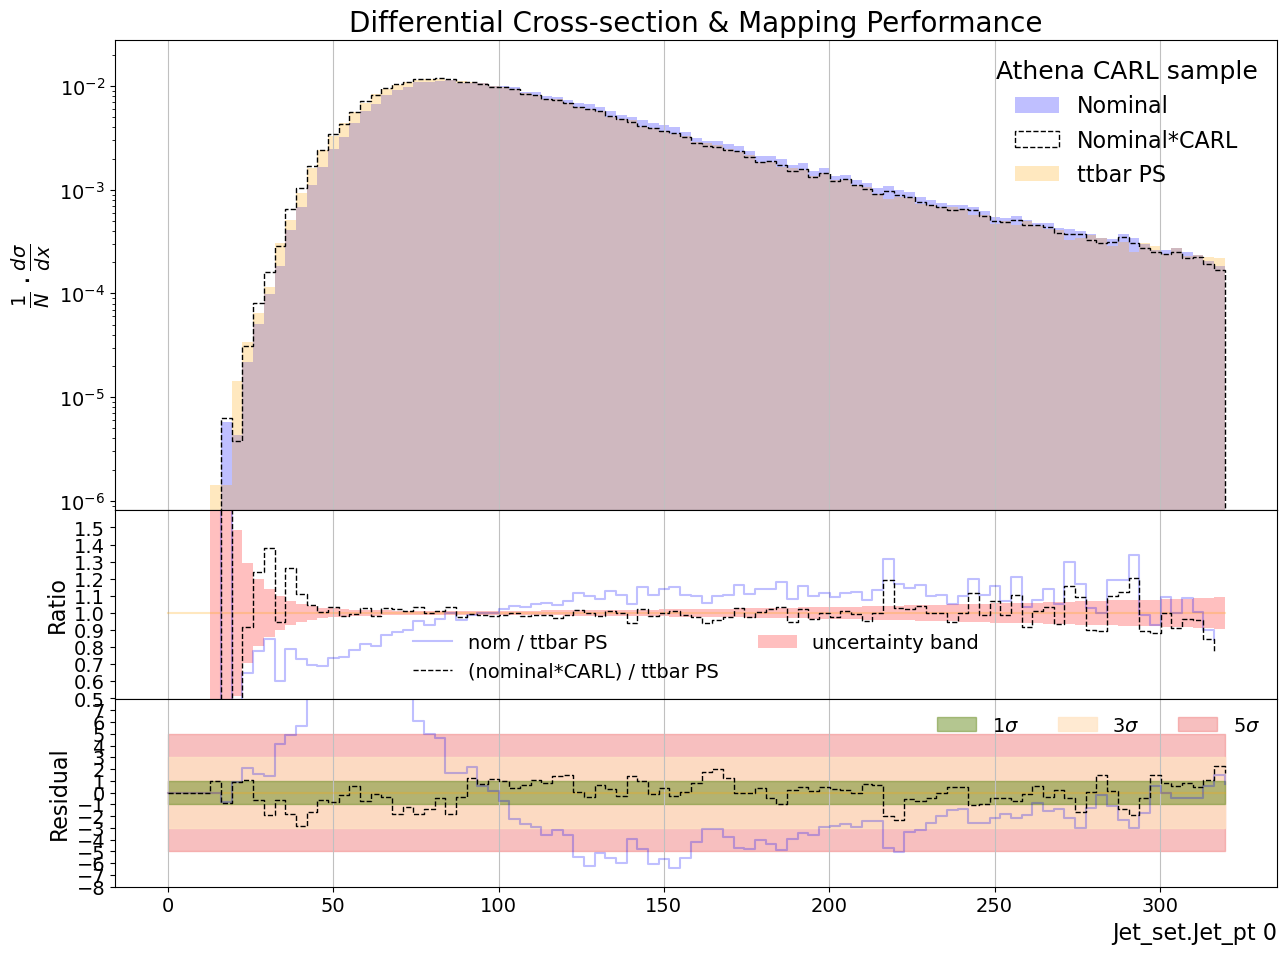

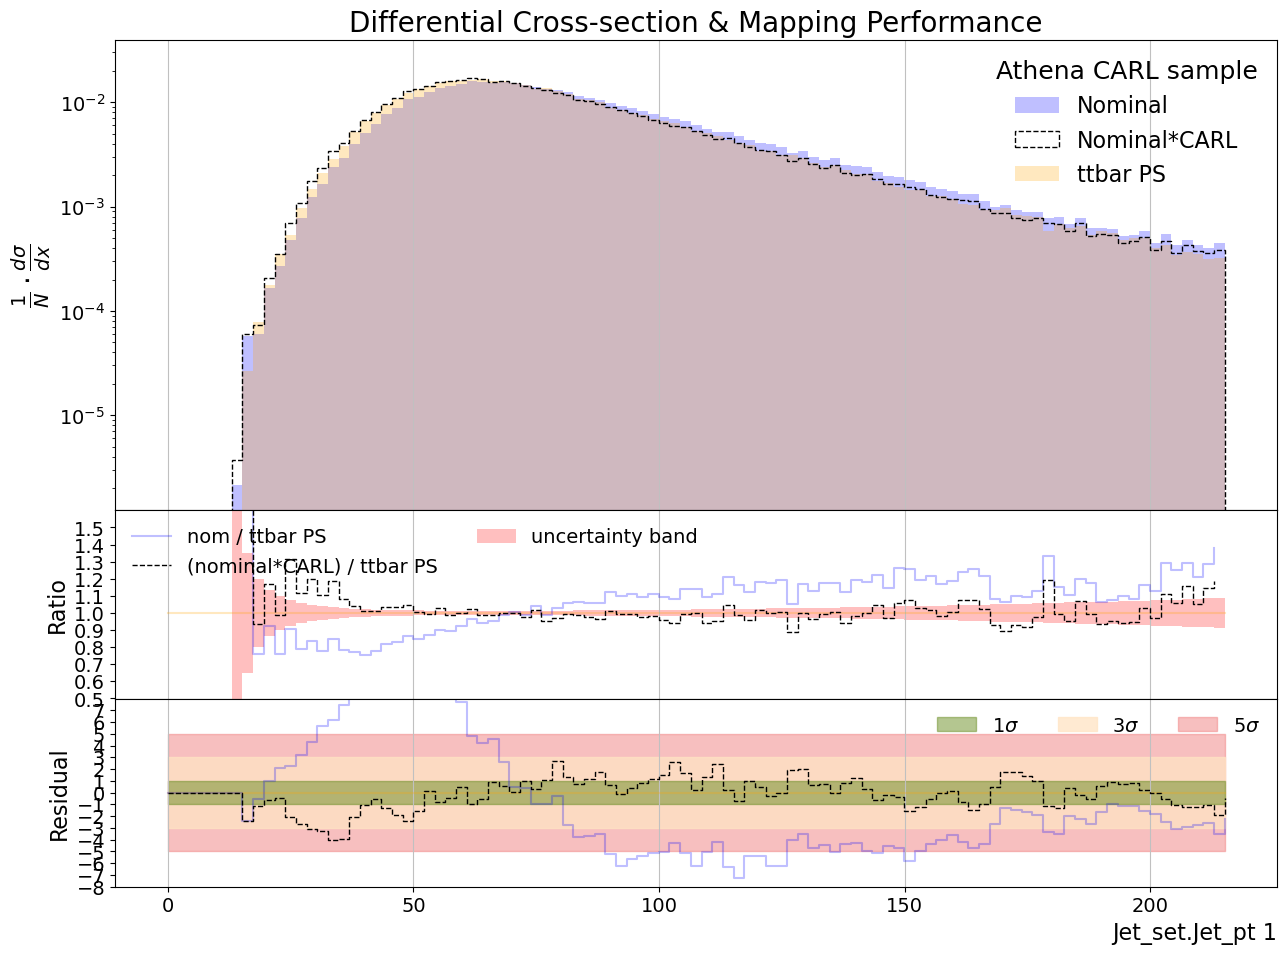

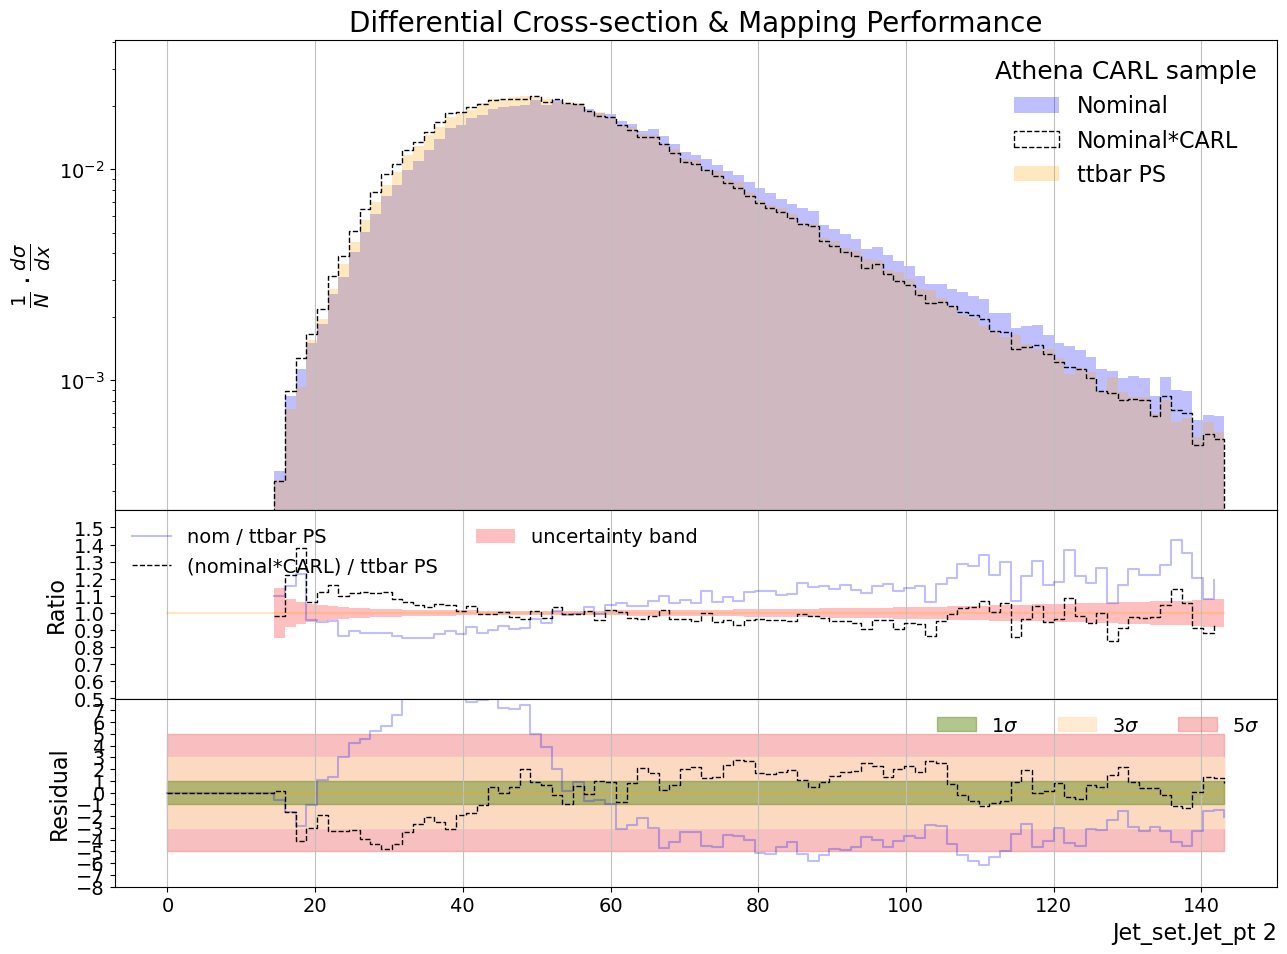

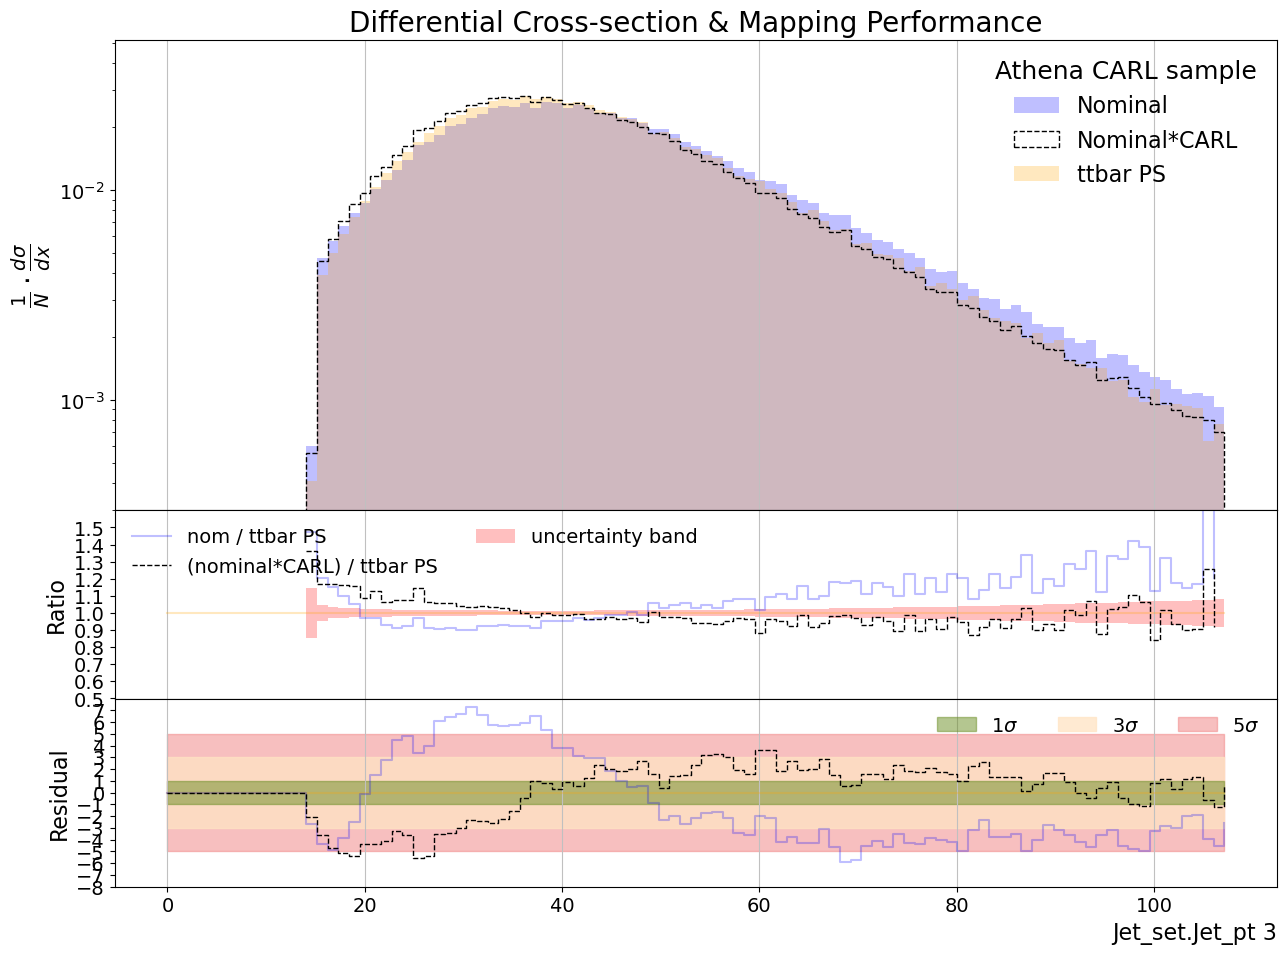

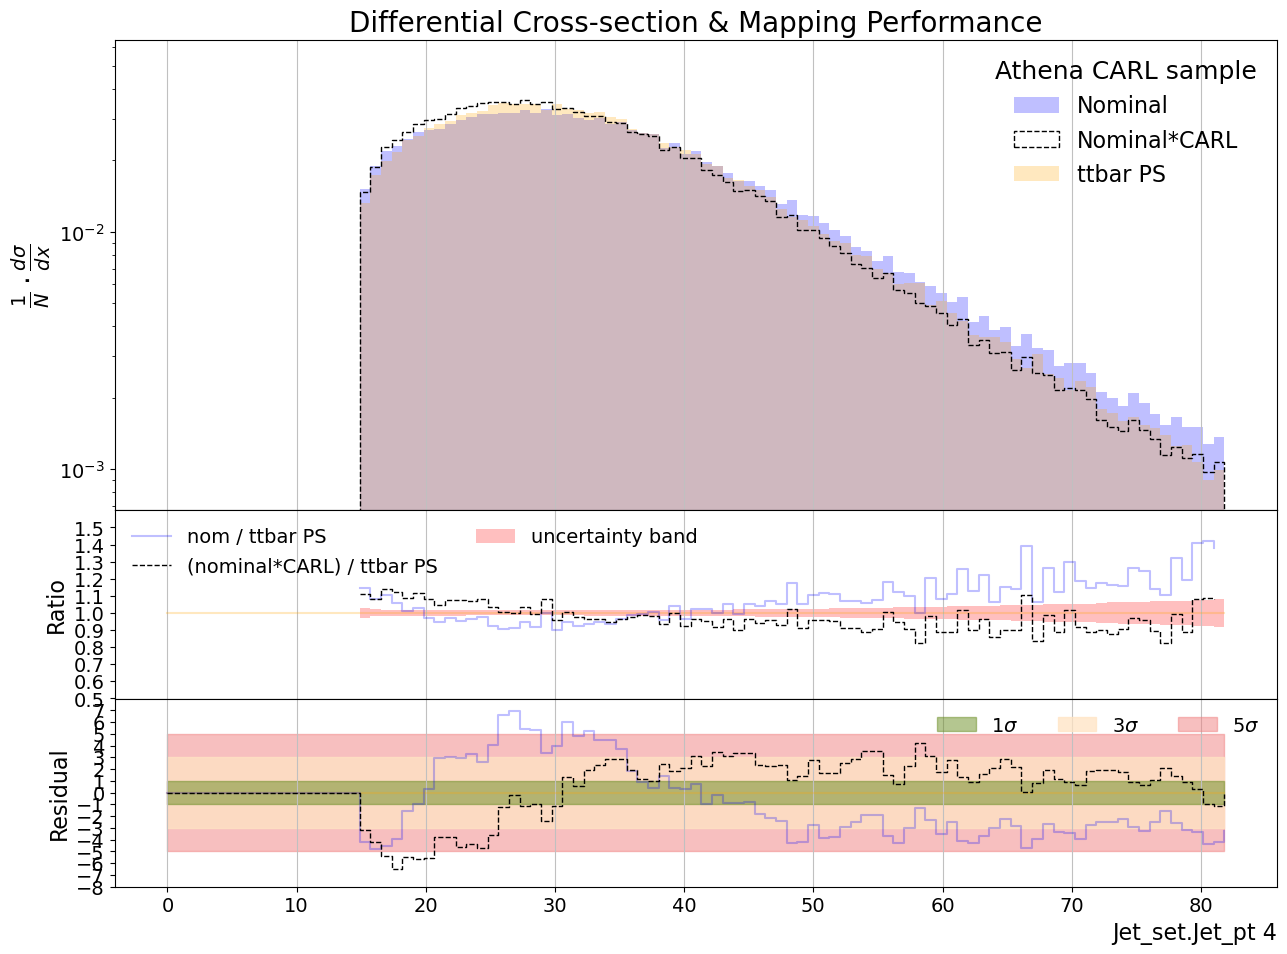

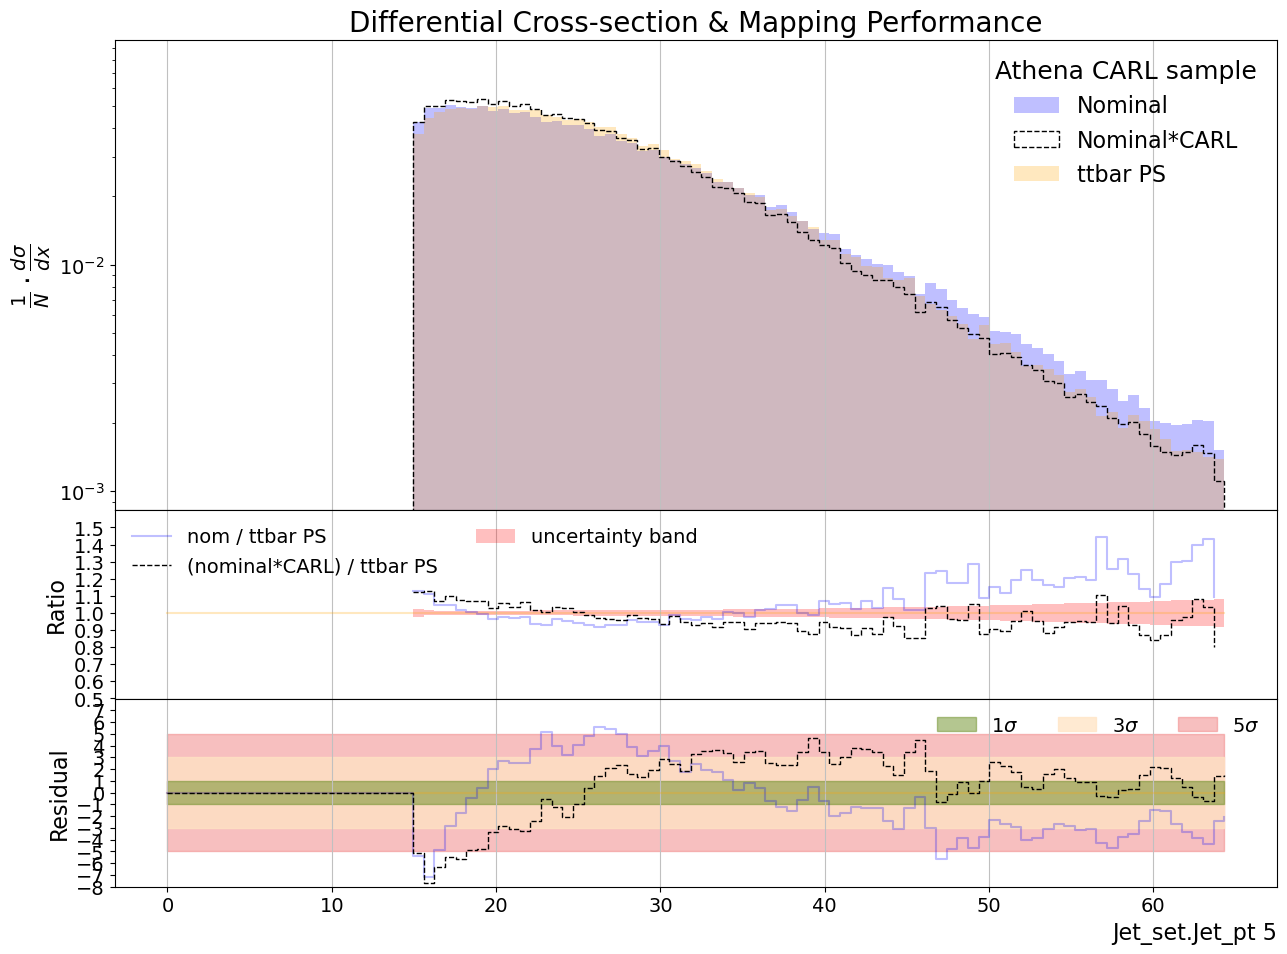

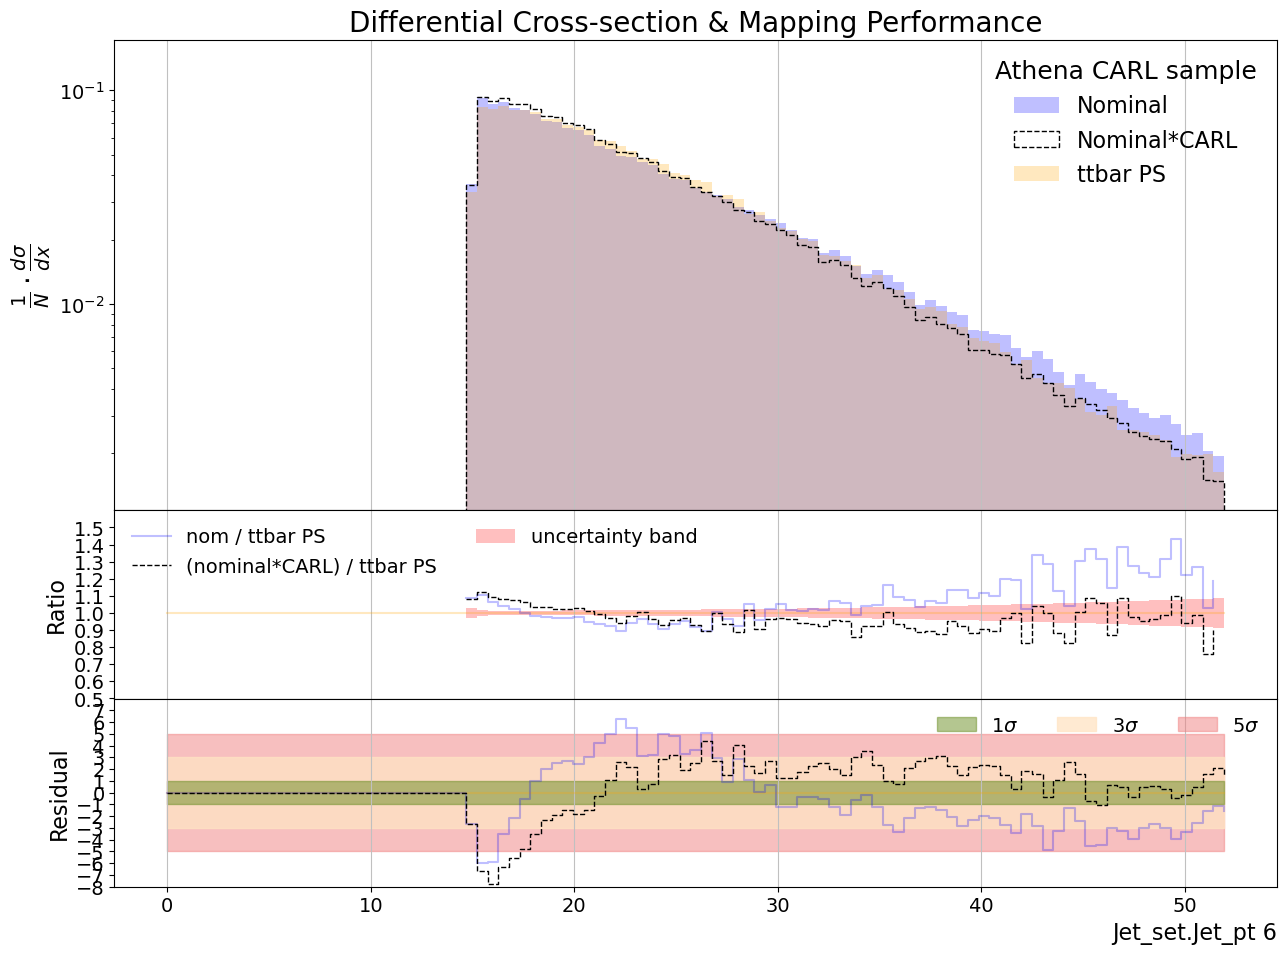

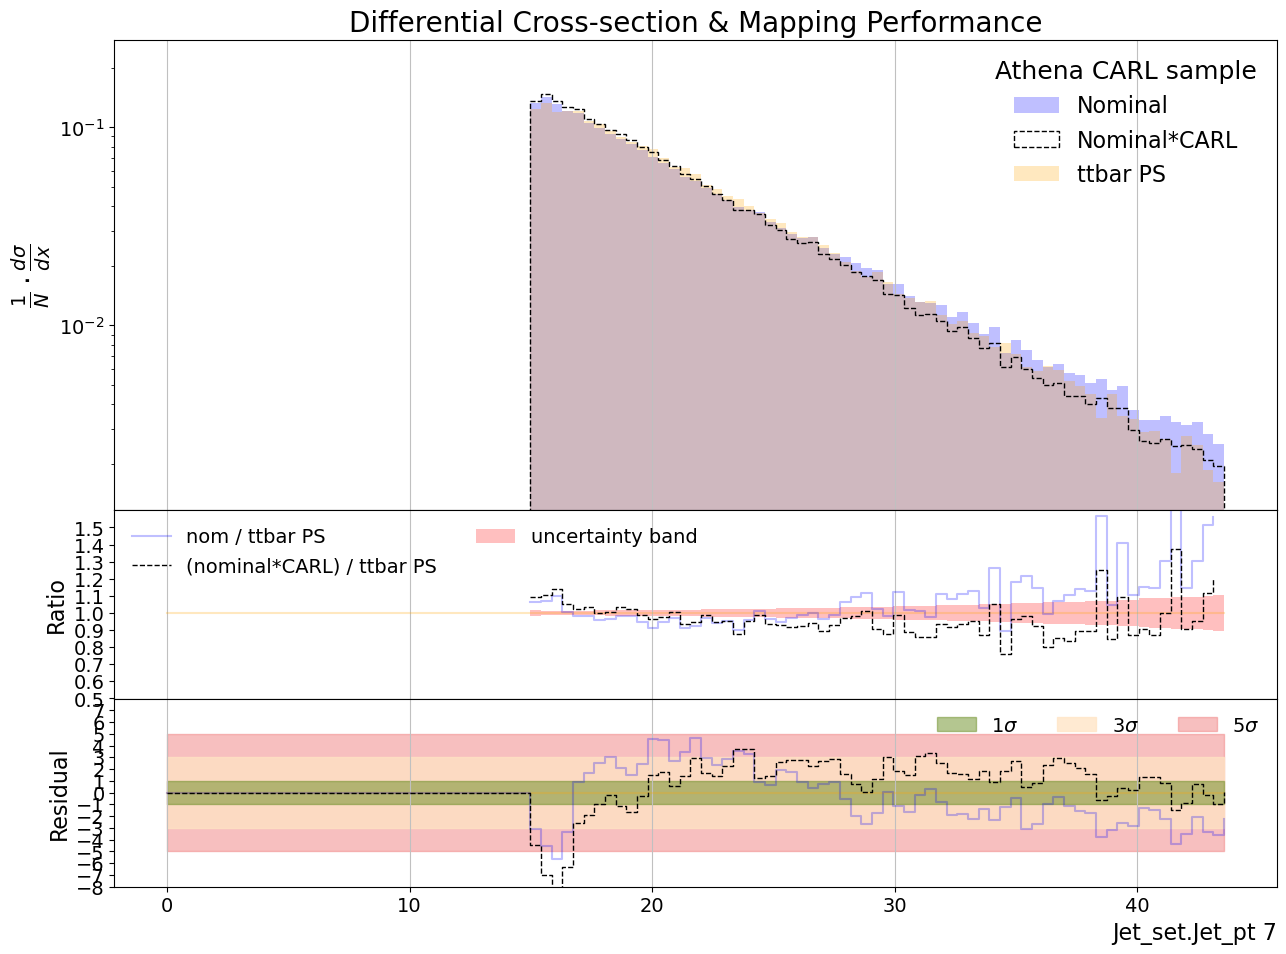

In [27]:
set_name = "Jet_set"
feature_name = "Jet_pt"


for i in range(8):
    carl_plot.plot_carl_reweighting(test_nominal_generator_data, test_PS_var_generator_data, r_hats, features,
                                    set_name, index=i, subfeature_name=feature_name, sort_feature="Jet_pt",
                                    alternate_name="ttbar PS", nominal_mask=np.isfinite, alternate_mask=np.isfinite, saveAs="plots/{}_{}{}.png".format(set_name, feature_name, i))

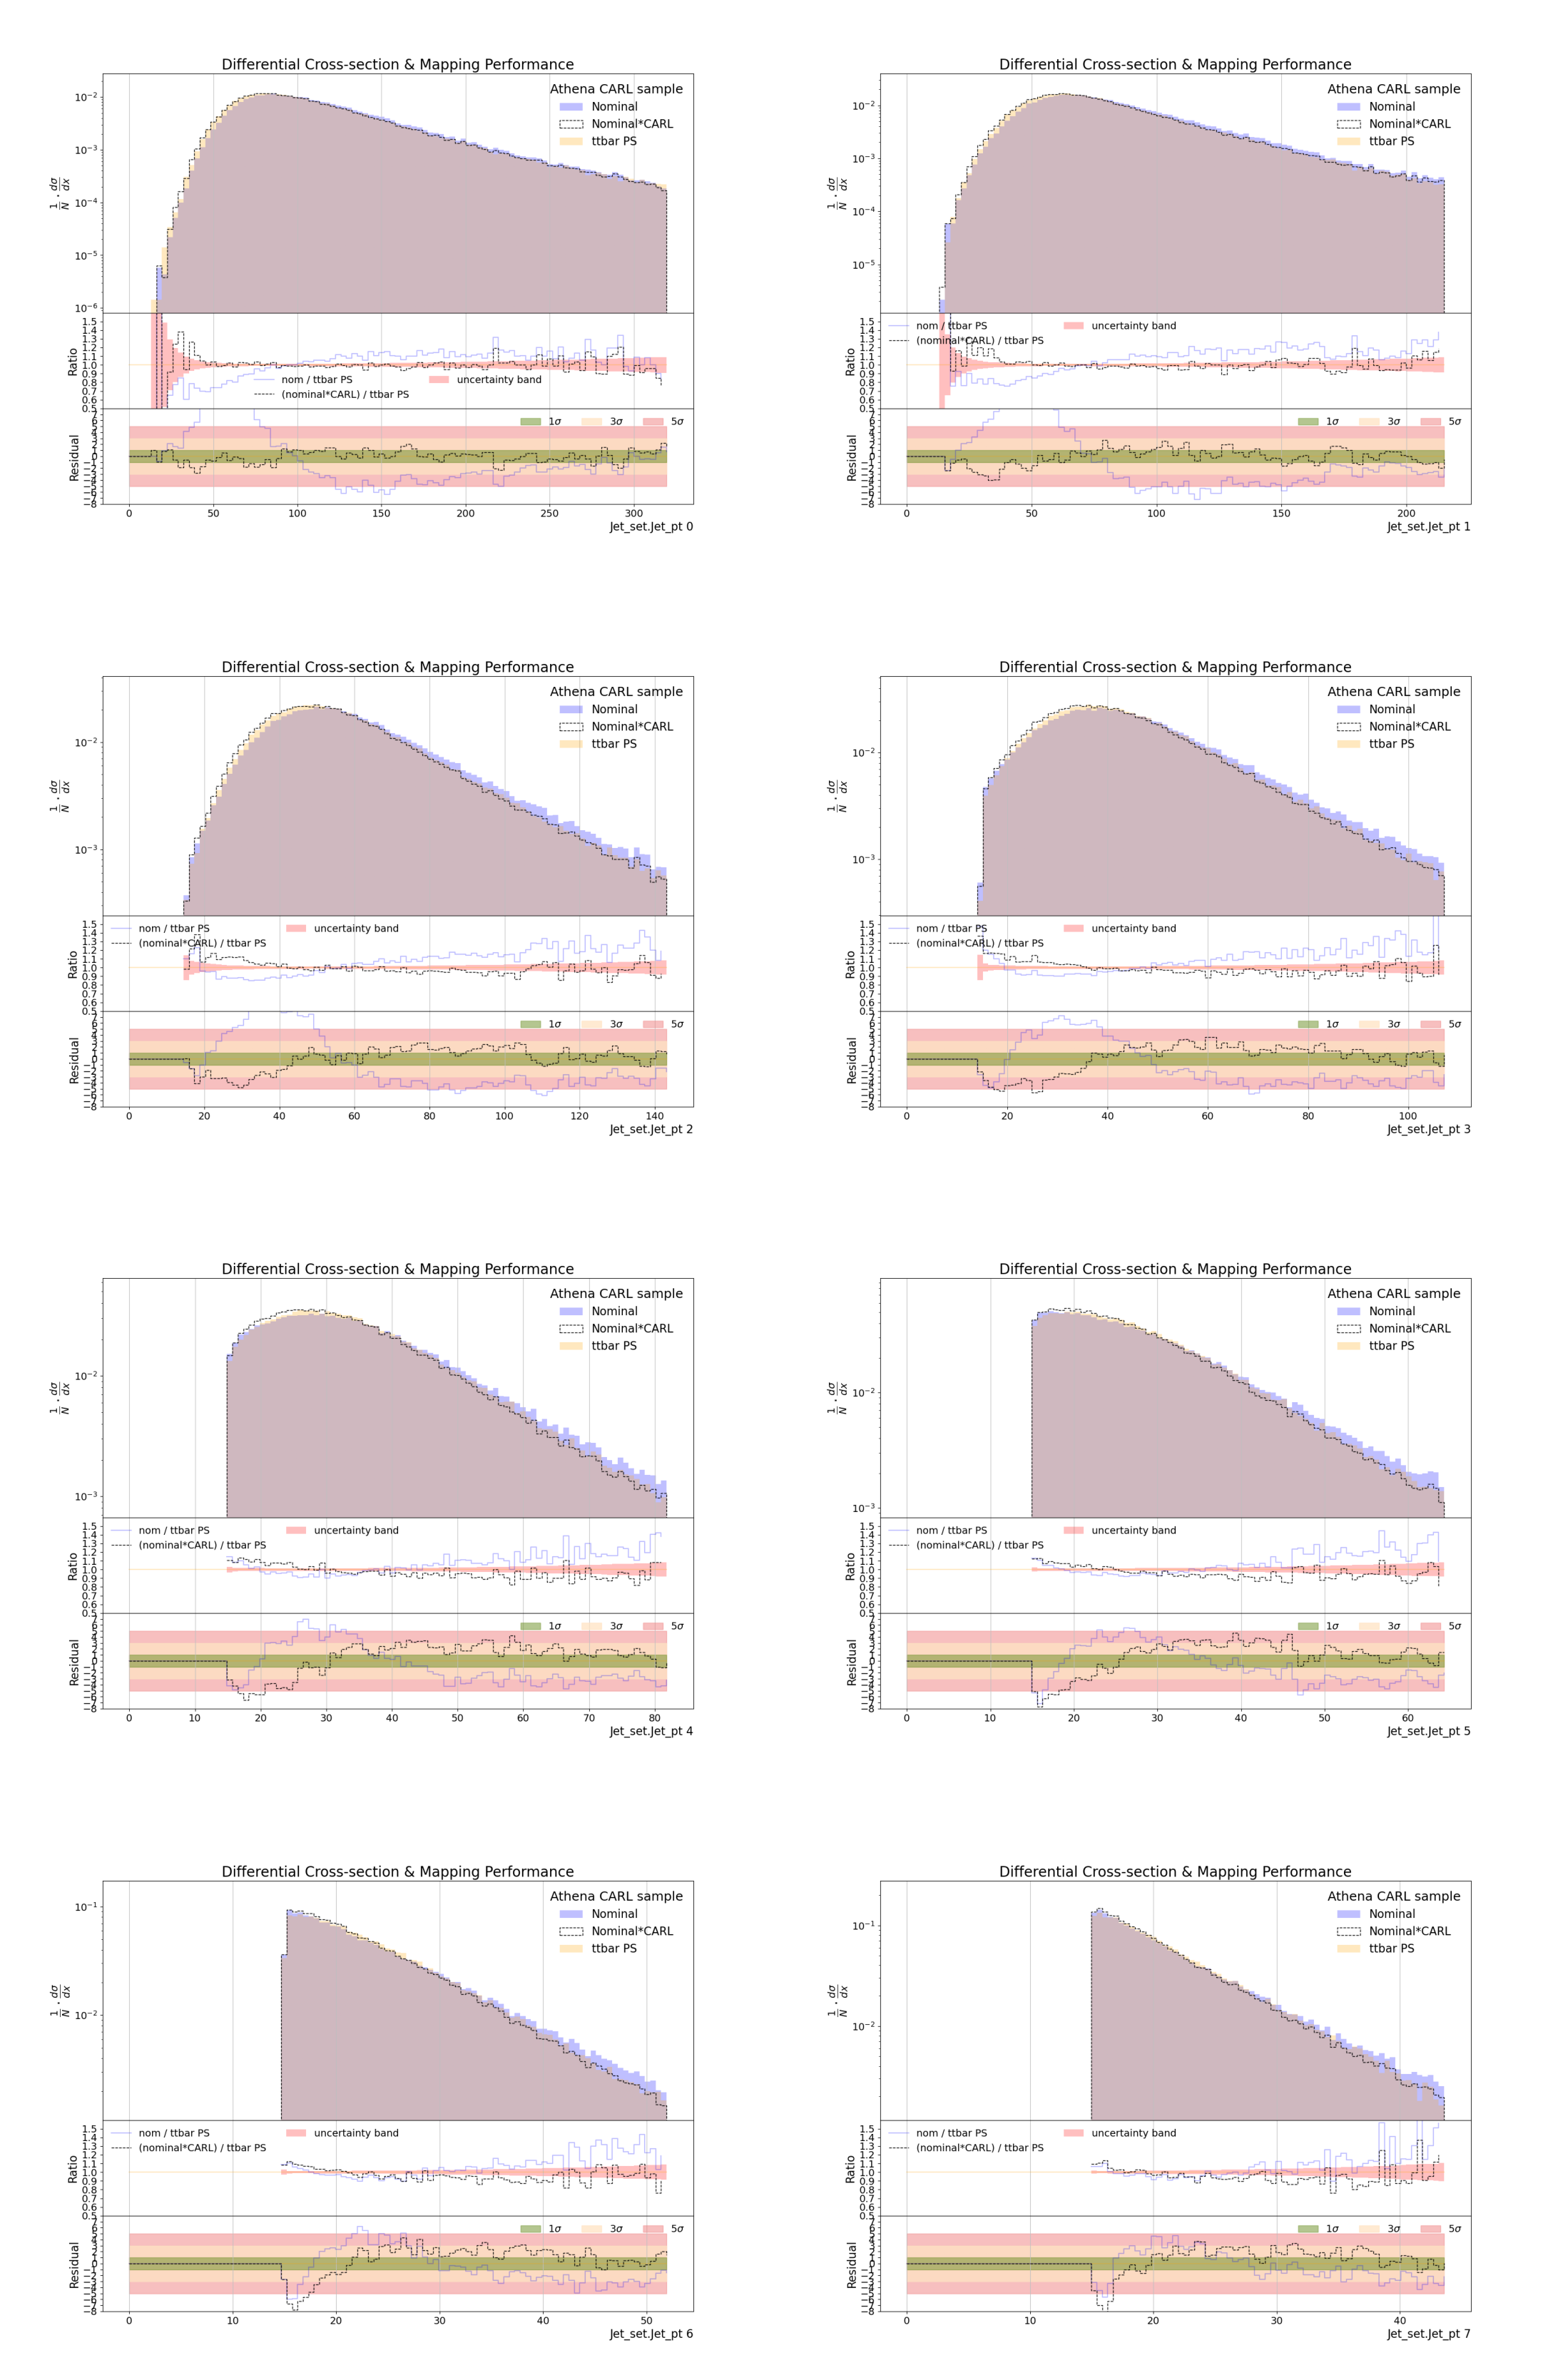

In [29]:
nrows = 4
ncolumns = 2

fig, axs = plt.subplots(nrows, ncolumns, figsize=(22,34))

set_name = "Jet_set"
feature_name = "Jet_pt"

for i in range(nrows):
    for j in range(ncolumns):
        im = plt.imread("plots/{}_{}{}.png".format(set_name, feature_name, i*ncolumns + j))
        axs[i,j].imshow(im)
        axs[i,j].axis('off')
fig.tight_layout()

100%|██████████| 1563/1563 [00:06<00:00, 257.72it/s]


199999
200000


100%|██████████| 1563/1563 [00:07<00:00, 206.87it/s]


199982
199993


100%|██████████| 1563/1563 [00:05<00:00, 267.38it/s]


199760
199833


100%|██████████| 1563/1563 [00:06<00:00, 241.50it/s]


197917
198498


100%|██████████| 1563/1563 [00:09<00:00, 157.73it/s]


190027
192492


100%|██████████| 1563/1563 [00:18<00:00, 83.05it/s]


170290
176687


100%|██████████| 1563/1563 [00:33<00:00, 46.79it/s]


138637
149370


100%|██████████| 1563/1563 [00:52<00:00, 29.93it/s]


101995
114905


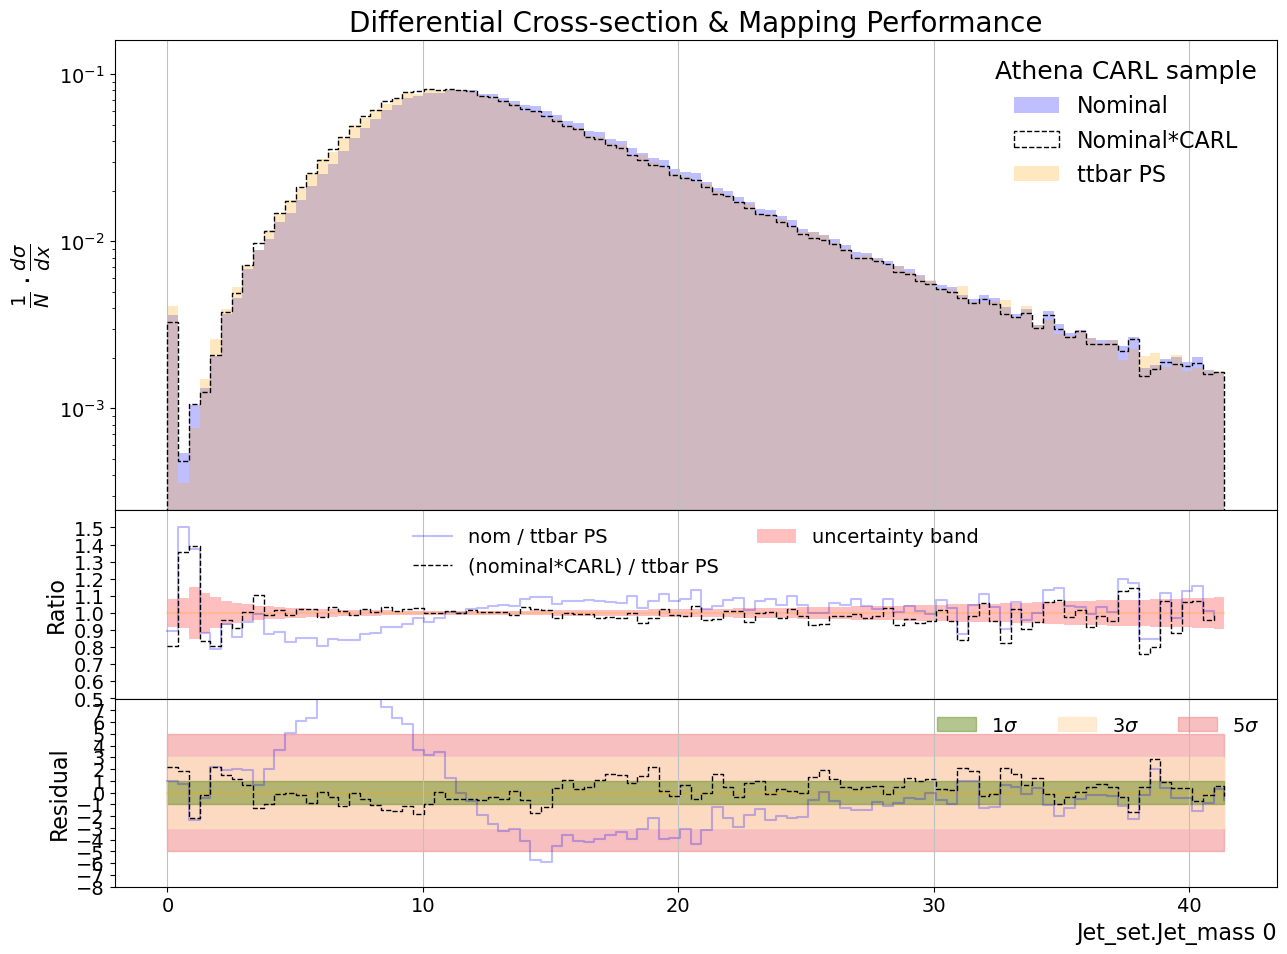

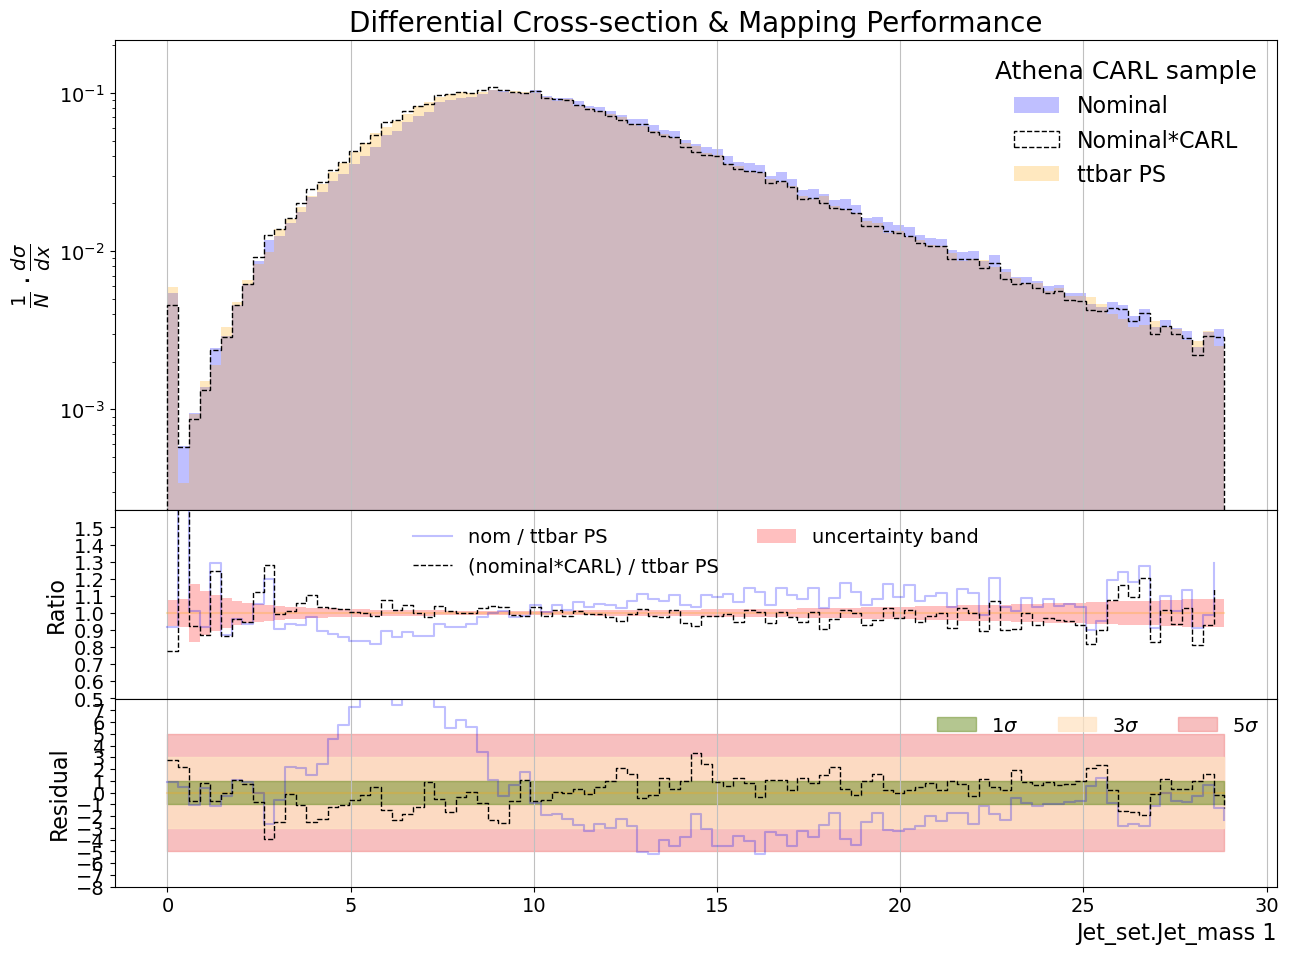

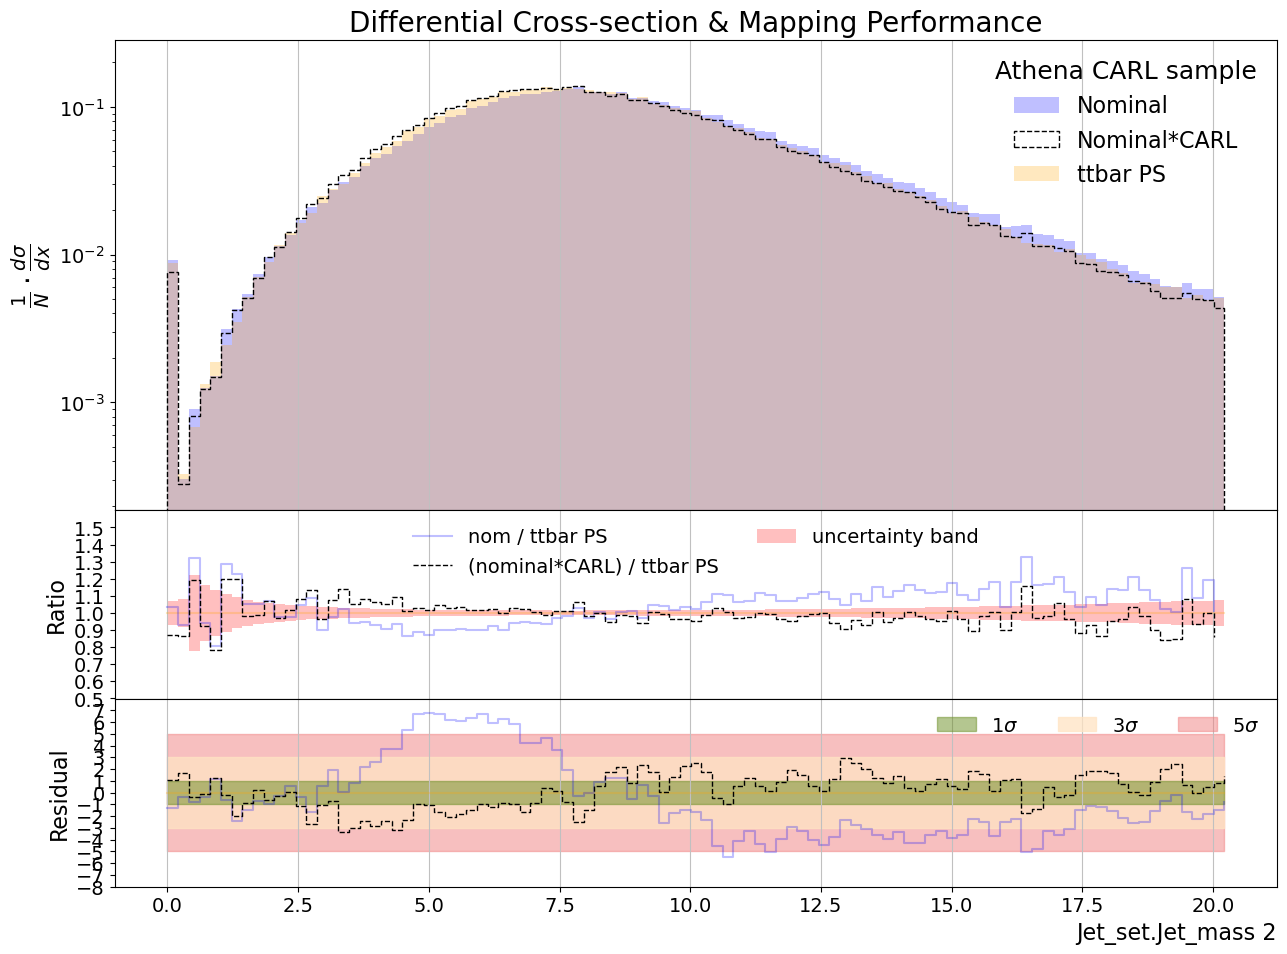

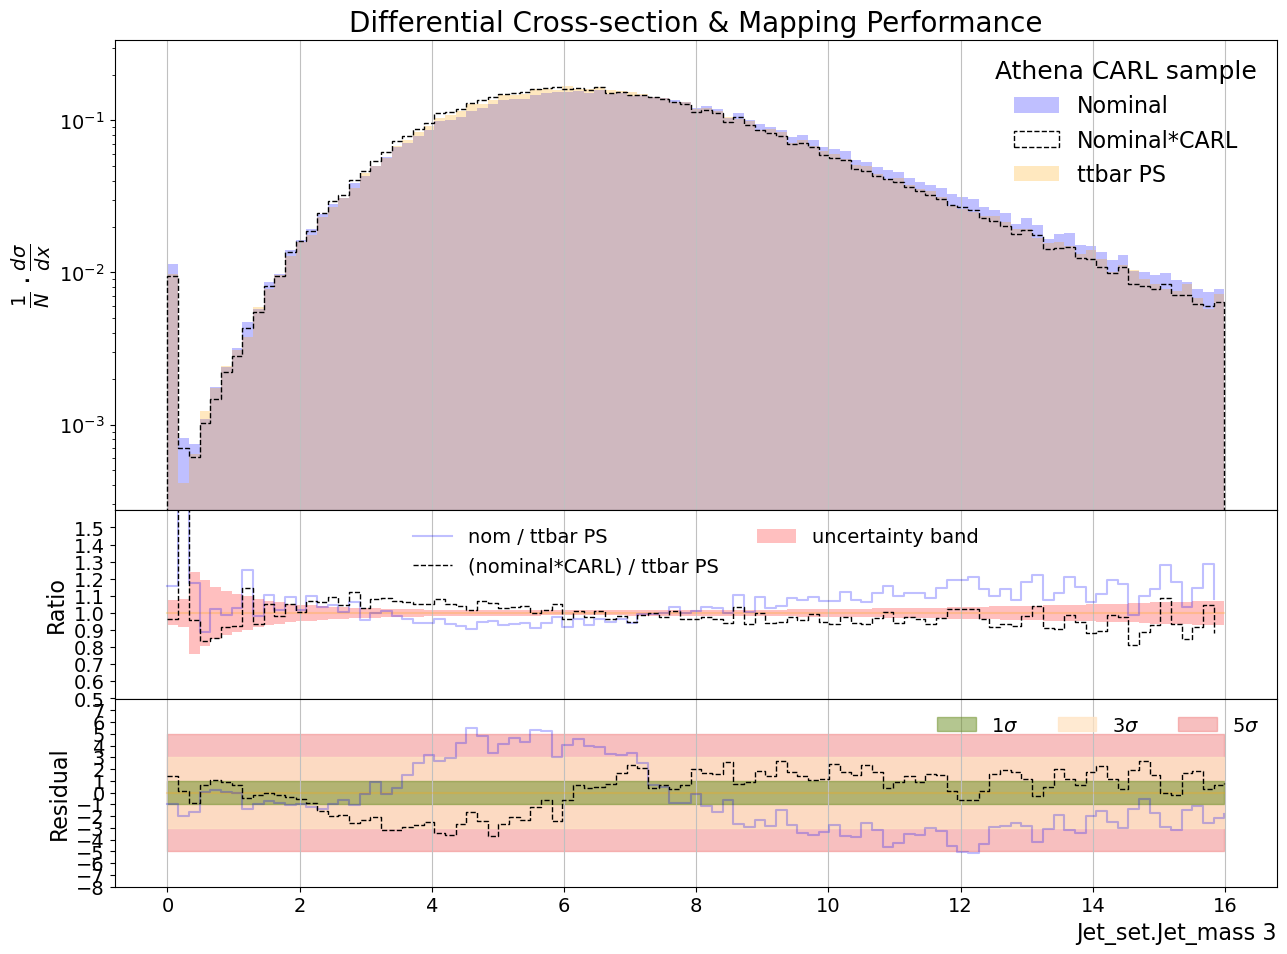

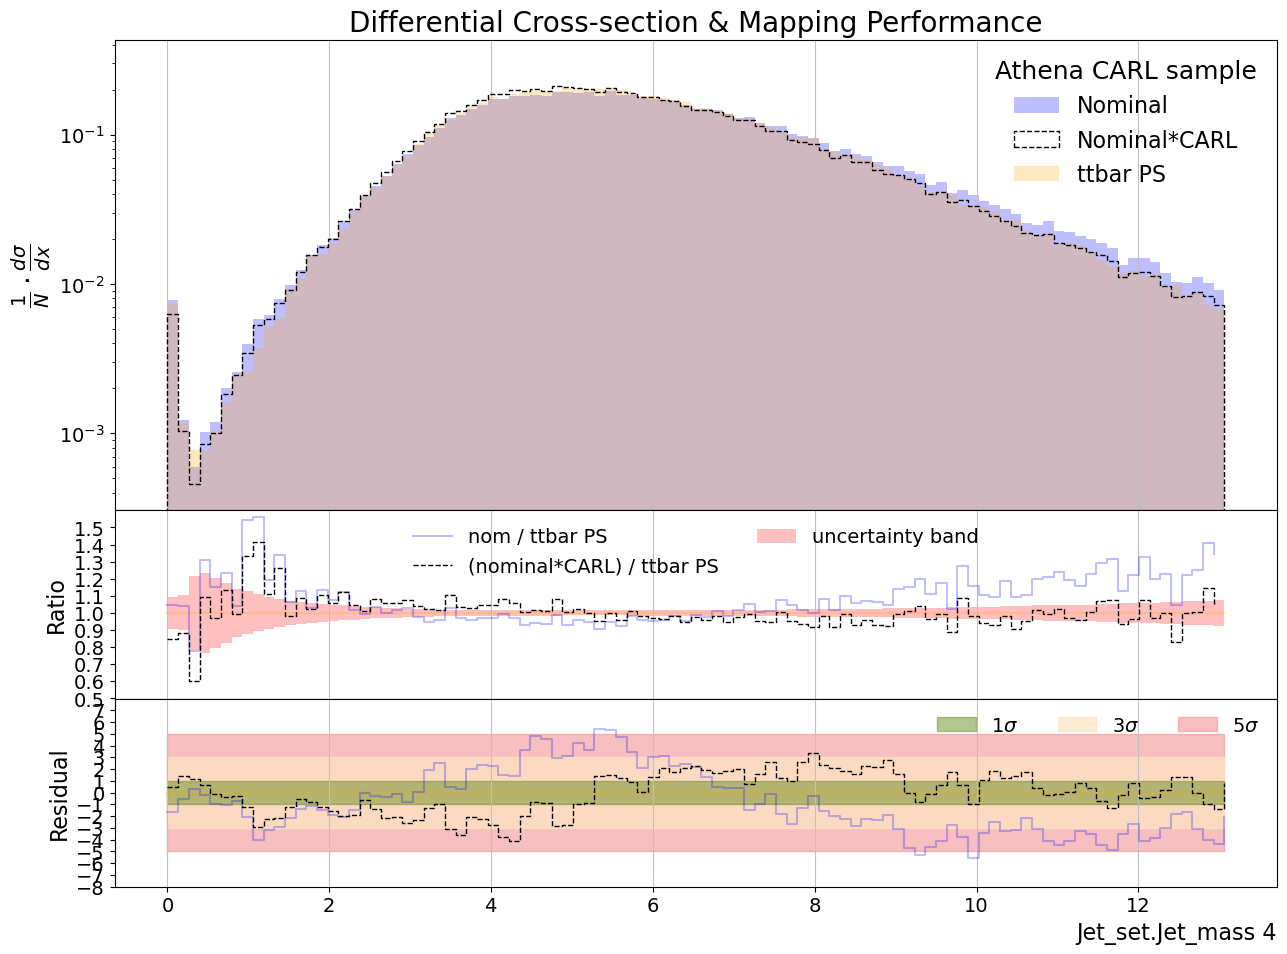

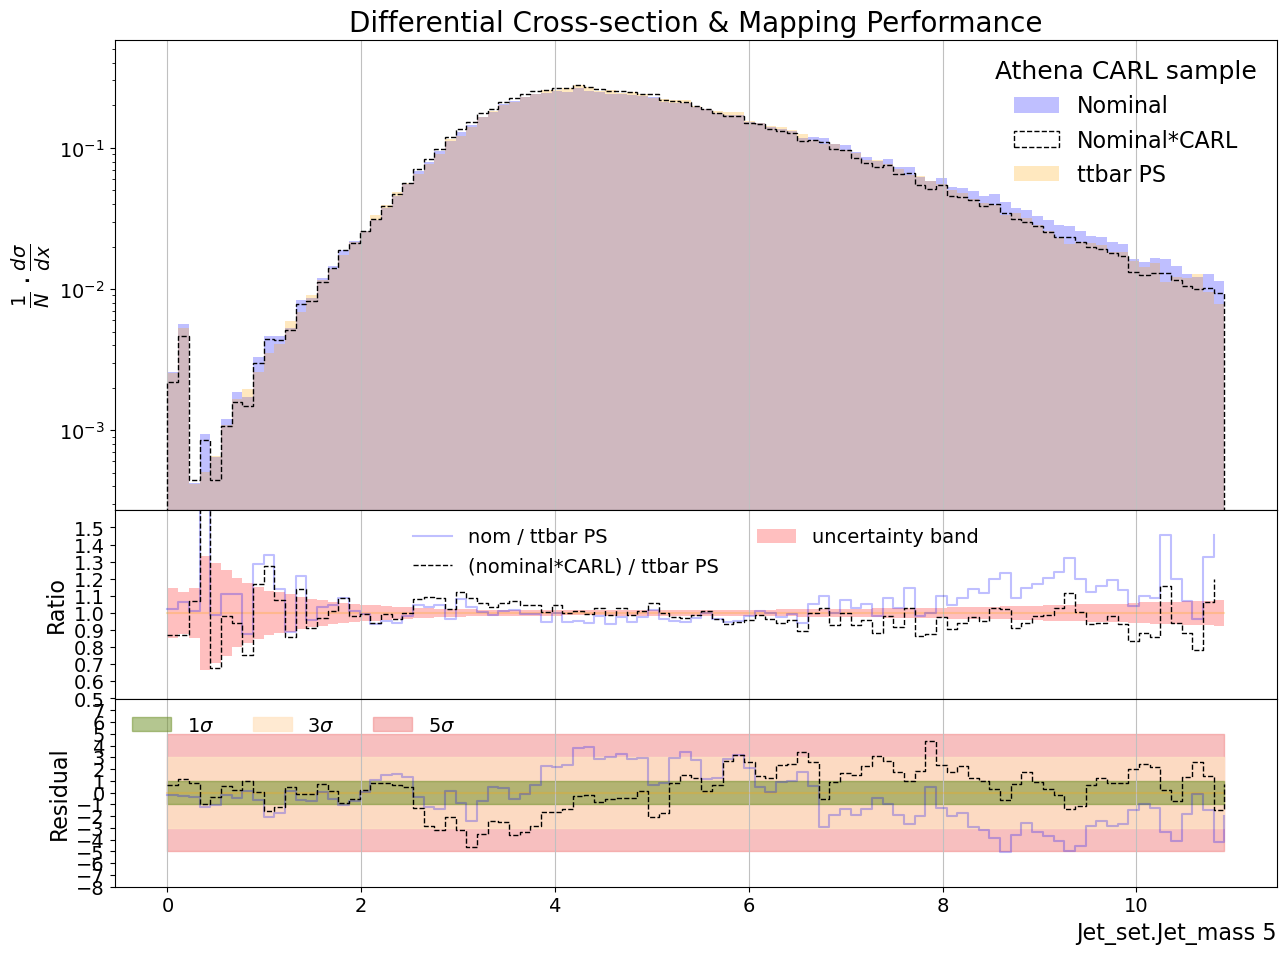

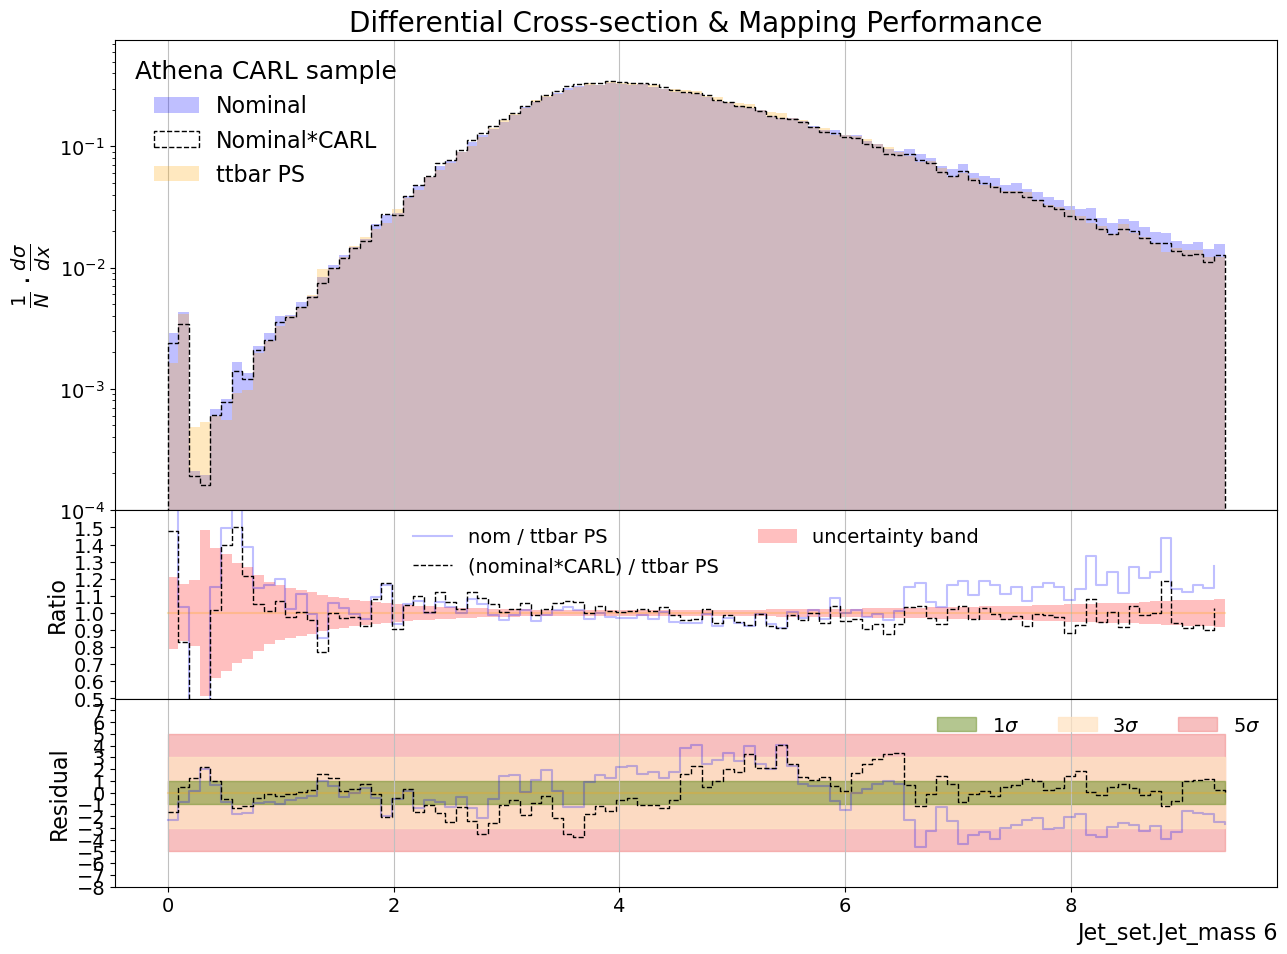

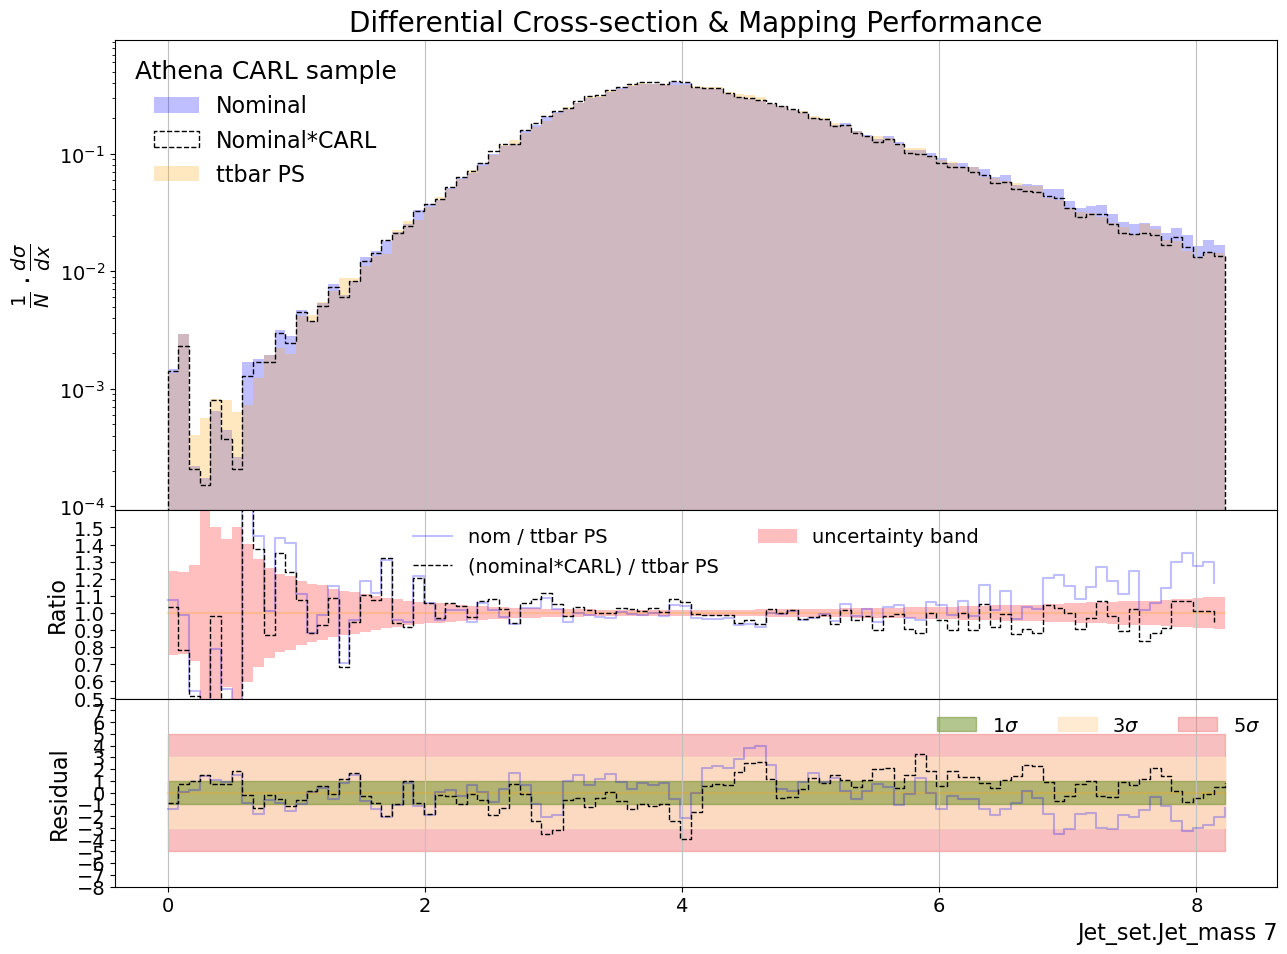

In [19]:
set_name = "Jet_set"
feature_name = "Jet_mass"

for i in range(8):
    carl_plot.plot_carl_reweighting(test_nominal_generator_data, test_PS_var_generator_data, r_hats, features,
                                    set_name, index=i, subfeature_name=feature_name, sort_feature="Jet_pt",
                                    alternate_name="ttbar PS", nominal_mask=np.isfinite, alternate_mask=np.isfinite, saveAs="plots/{}_{}{}.png".format(set_name, feature_name, i))

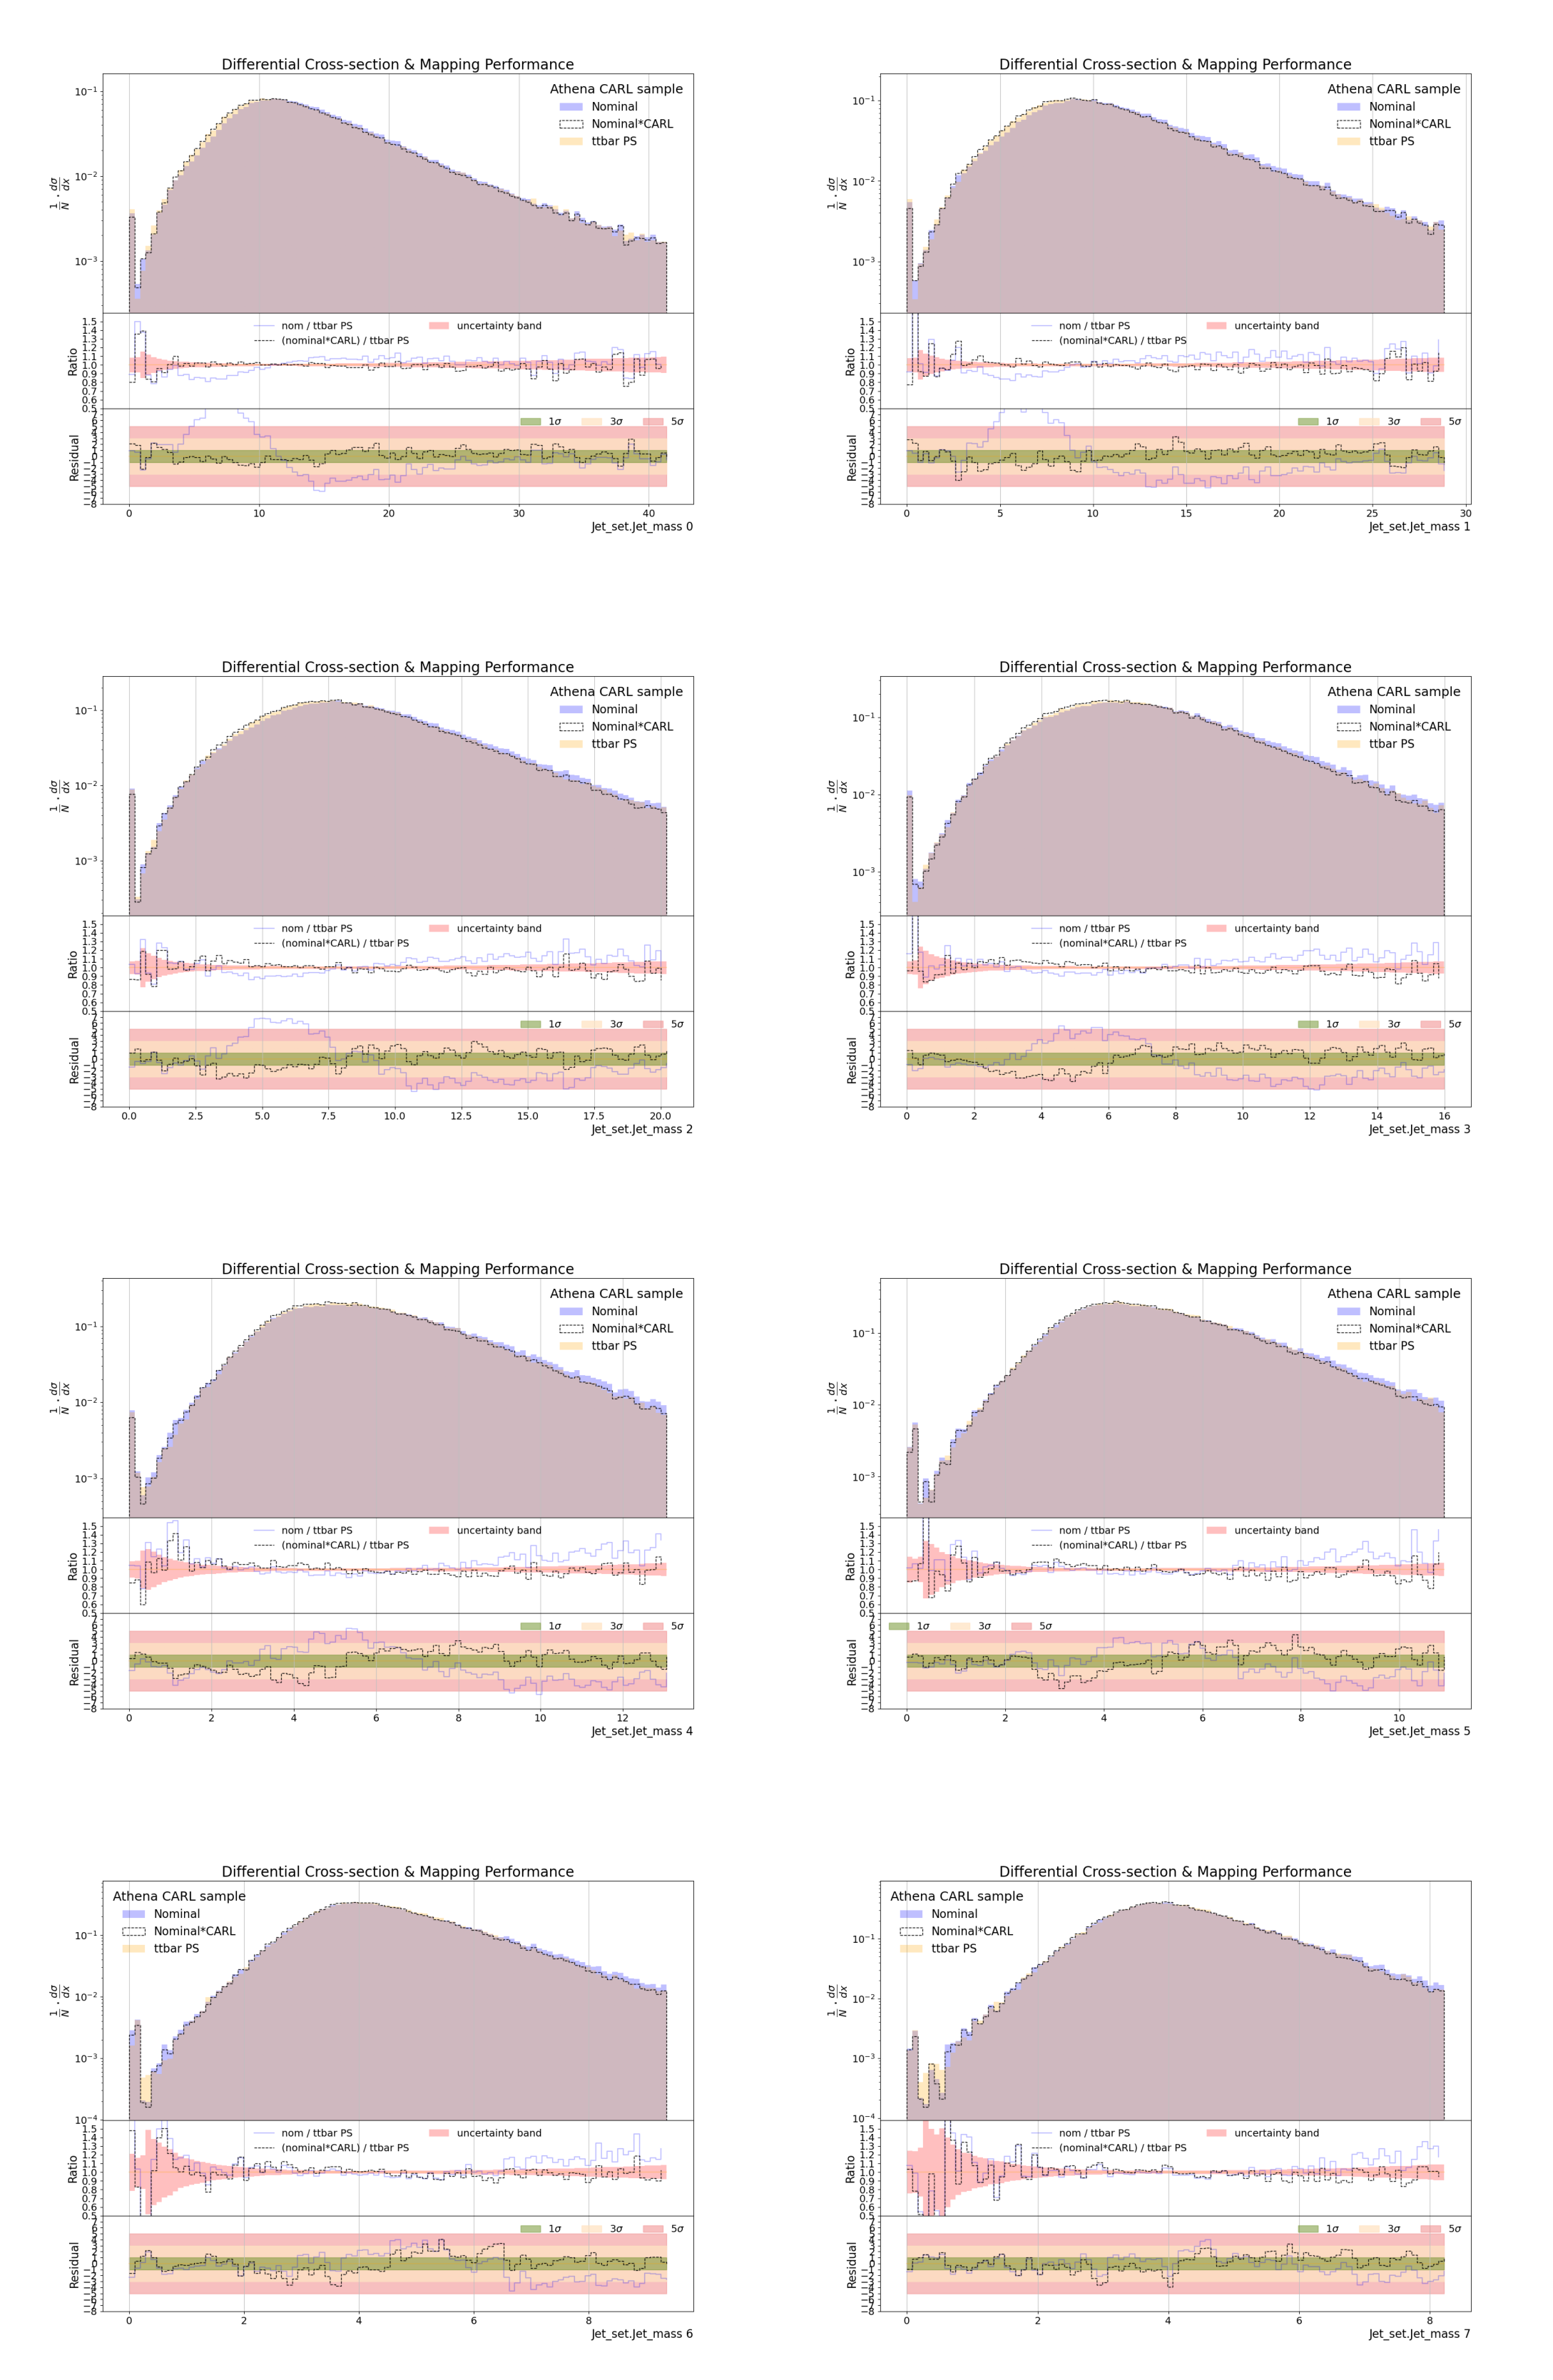

In [20]:
nrows = 4
ncolumns = 2

fig, axs = plt.subplots(nrows, ncolumns, figsize=(22,34))

set_name = "Jet_set"
feature_name = "Jet_mass"

for i in range(nrows):
    for j in range(ncolumns):
        im = plt.imread("plots/{}_{}{}.png".format(set_name, feature_name, i*ncolumns + j))
        axs[i,j].imshow(im)
        axs[i,j].axis('off')
fig.tight_layout()

100%|██████████| 1563/1563 [00:05<00:00, 272.33it/s]


199999
200000


100%|██████████| 1563/1563 [00:05<00:00, 280.81it/s]


199982
199993


100%|██████████| 1563/1563 [00:06<00:00, 245.00it/s]


199760
199833


100%|██████████| 1563/1563 [00:06<00:00, 232.84it/s]


197917
198498


100%|██████████| 1563/1563 [00:09<00:00, 157.91it/s]


190027
192492


100%|██████████| 1563/1563 [00:19<00:00, 78.63it/s]


170290
176687


100%|██████████| 1563/1563 [00:38<00:00, 40.77it/s]


138637
149370


100%|██████████| 1563/1563 [00:53<00:00, 29.04it/s]


101995
114905


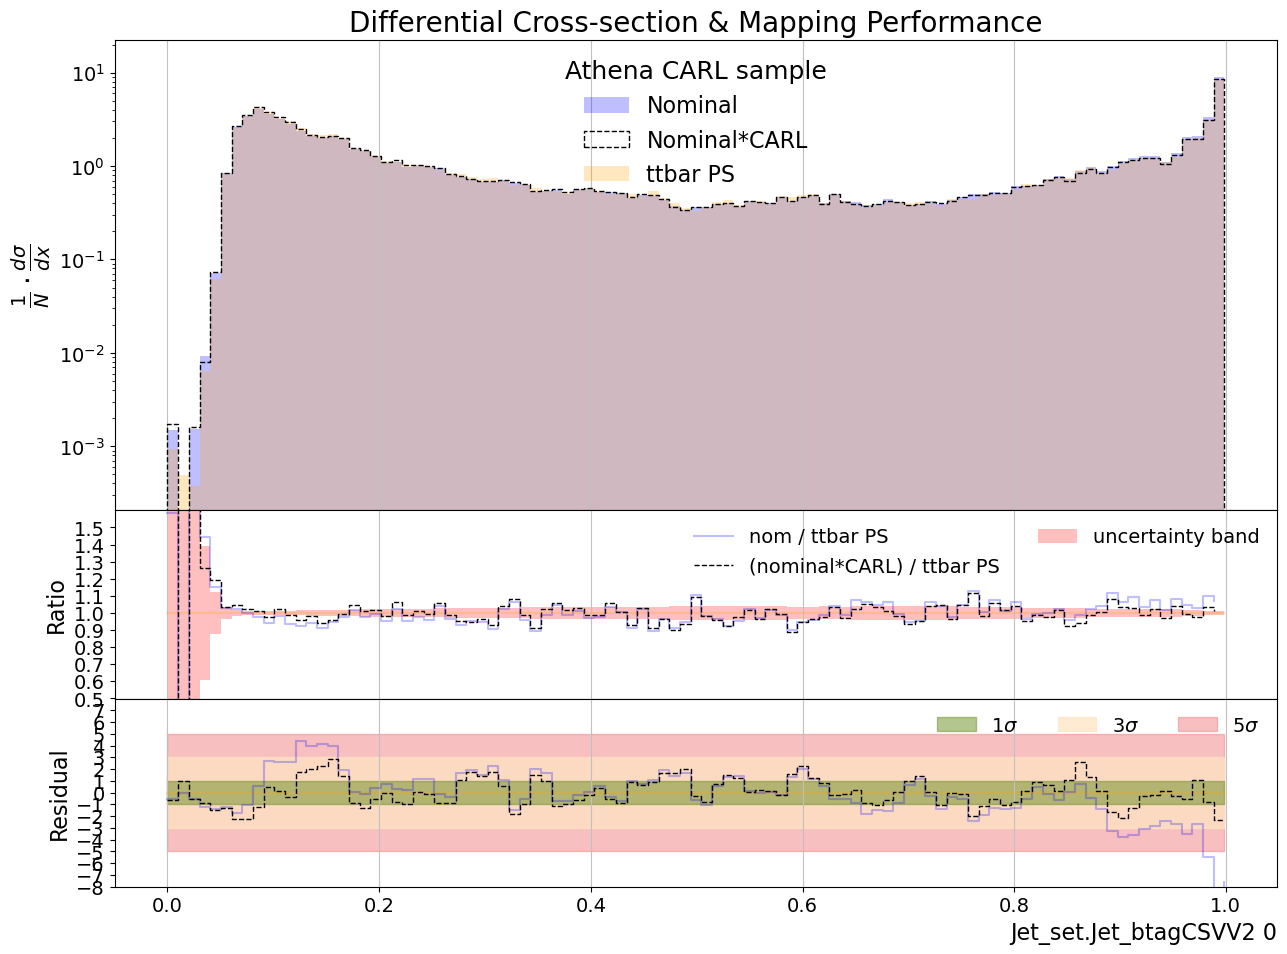

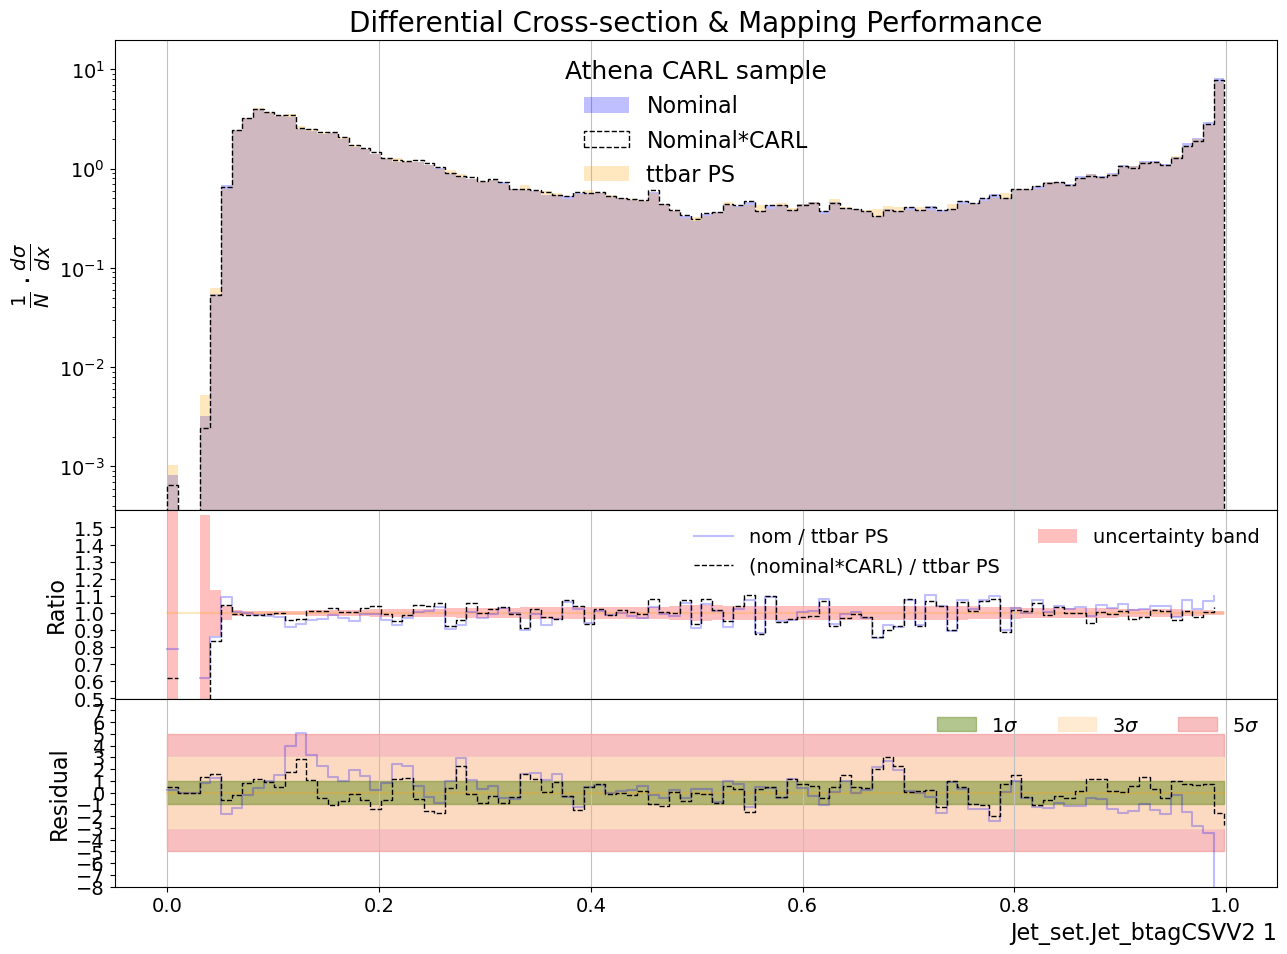

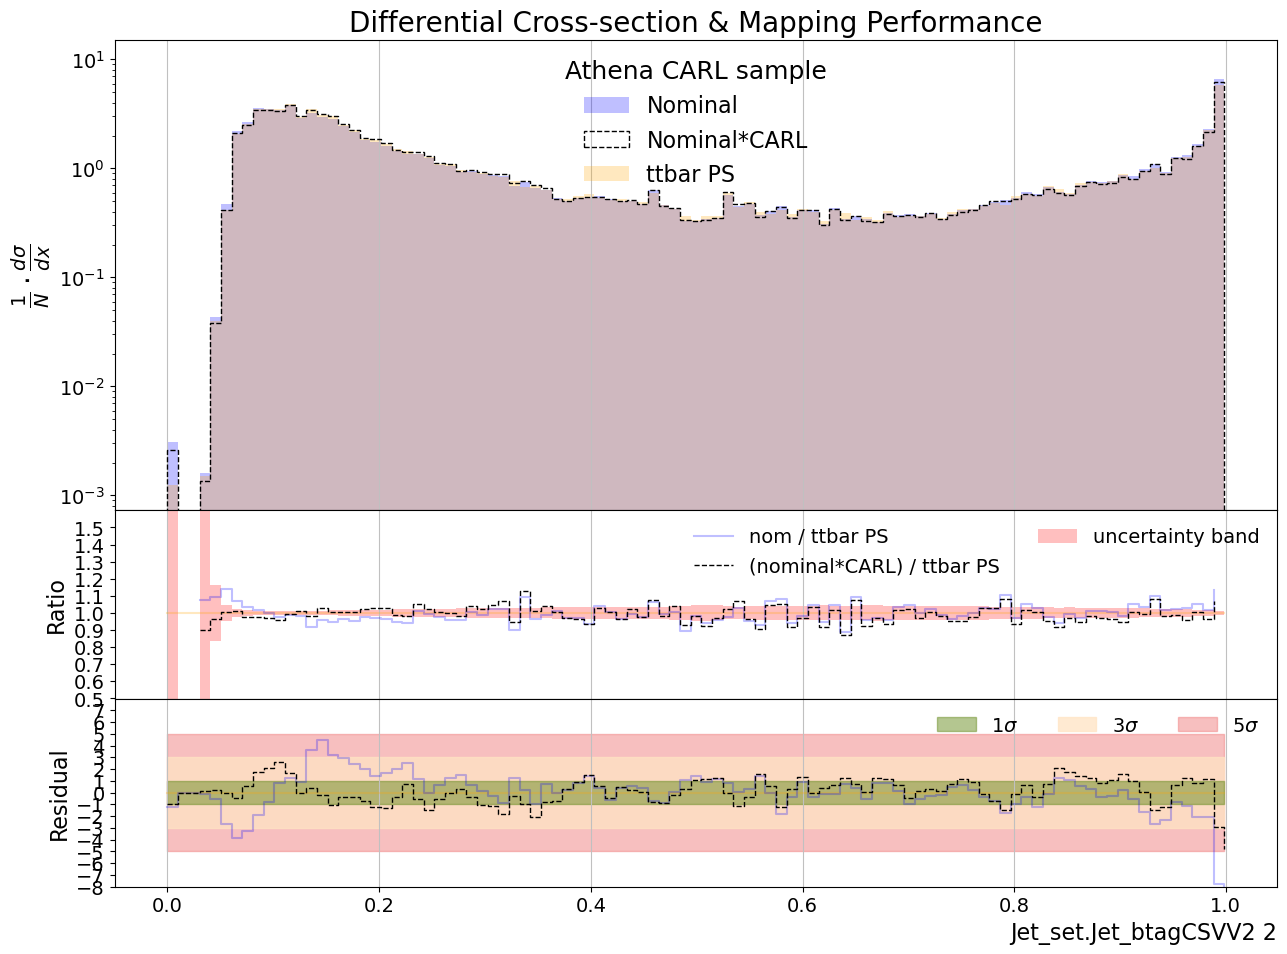

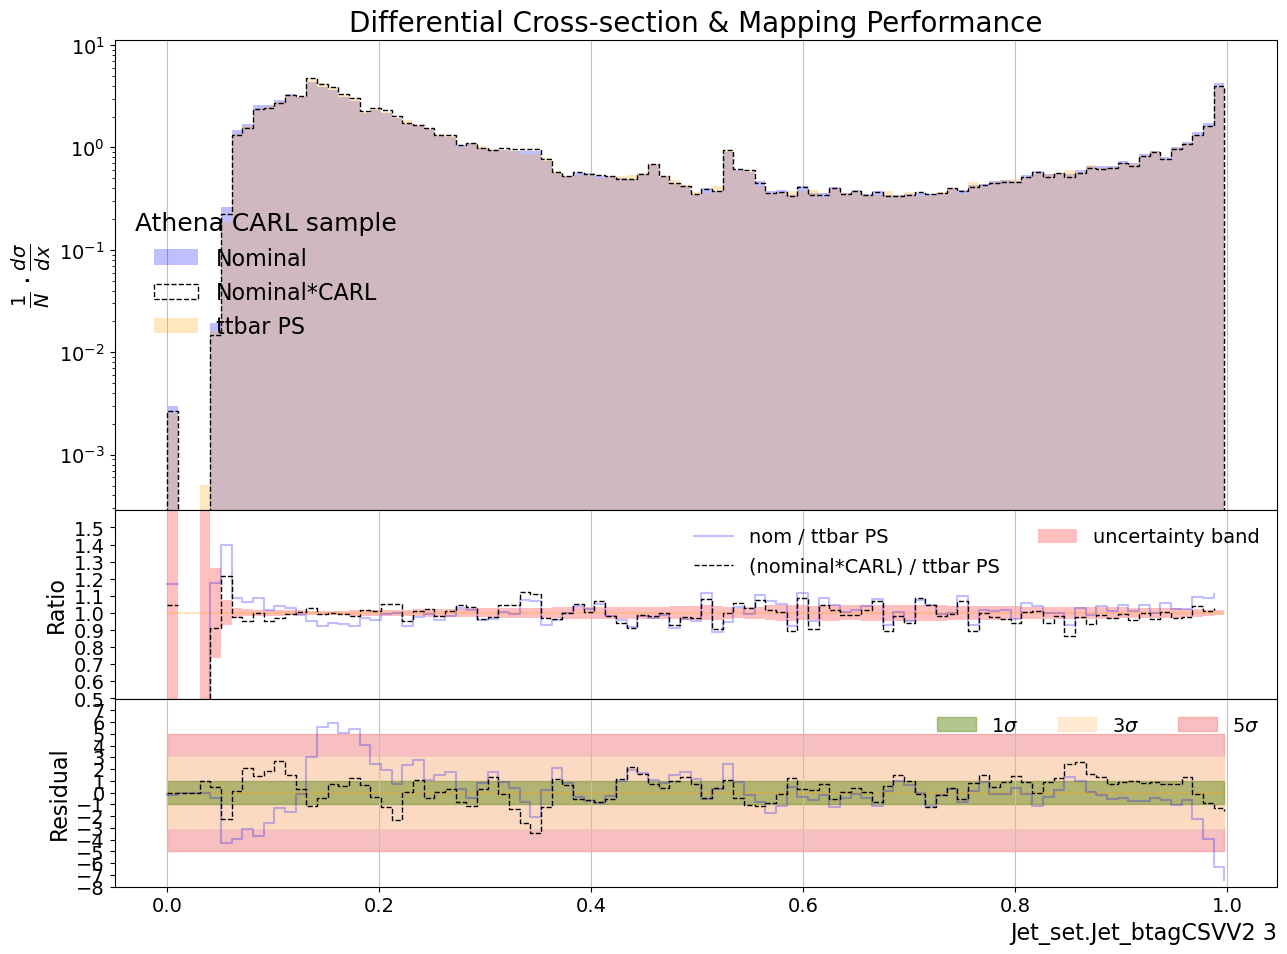

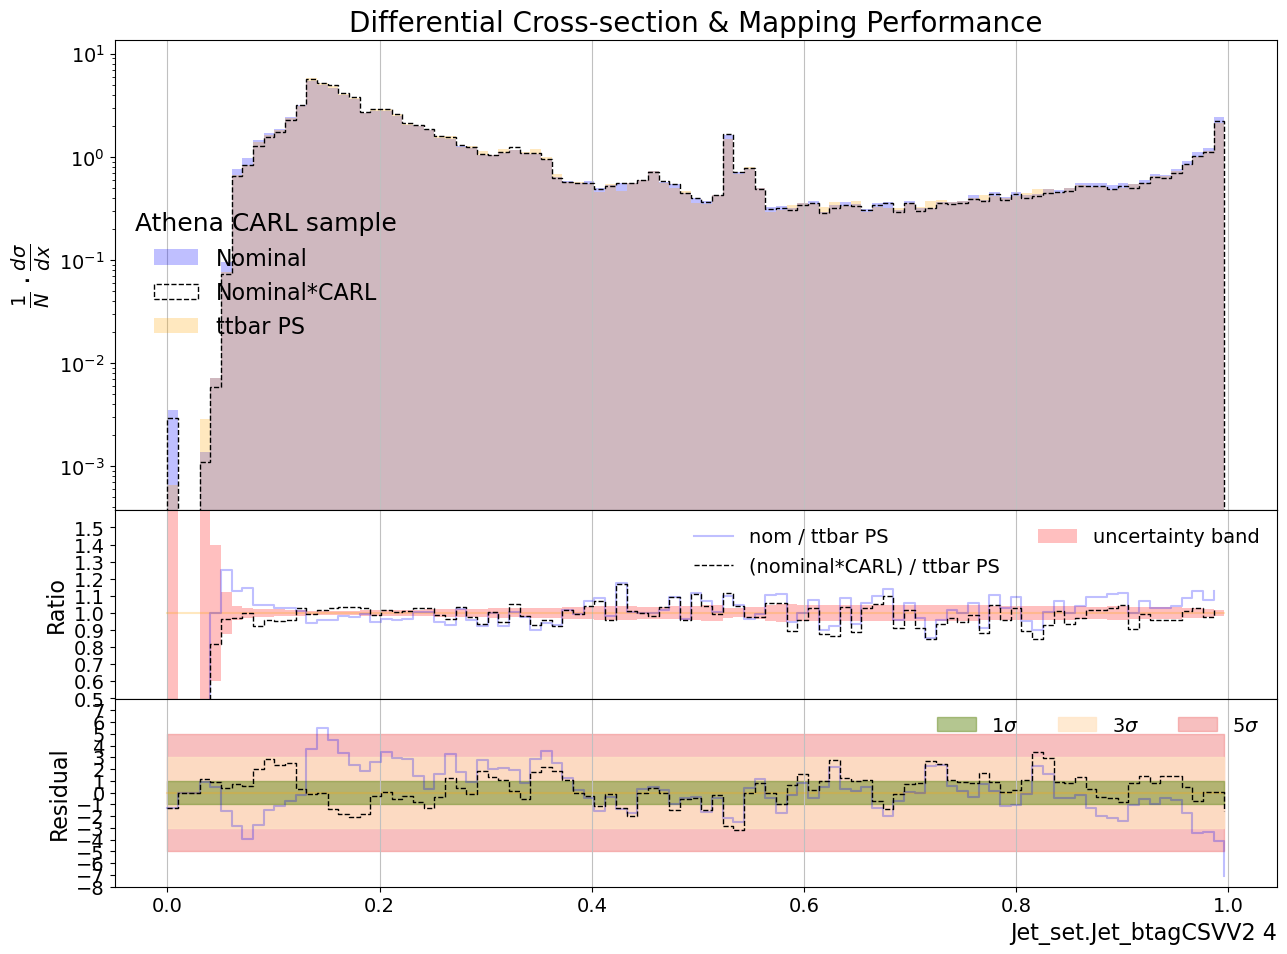

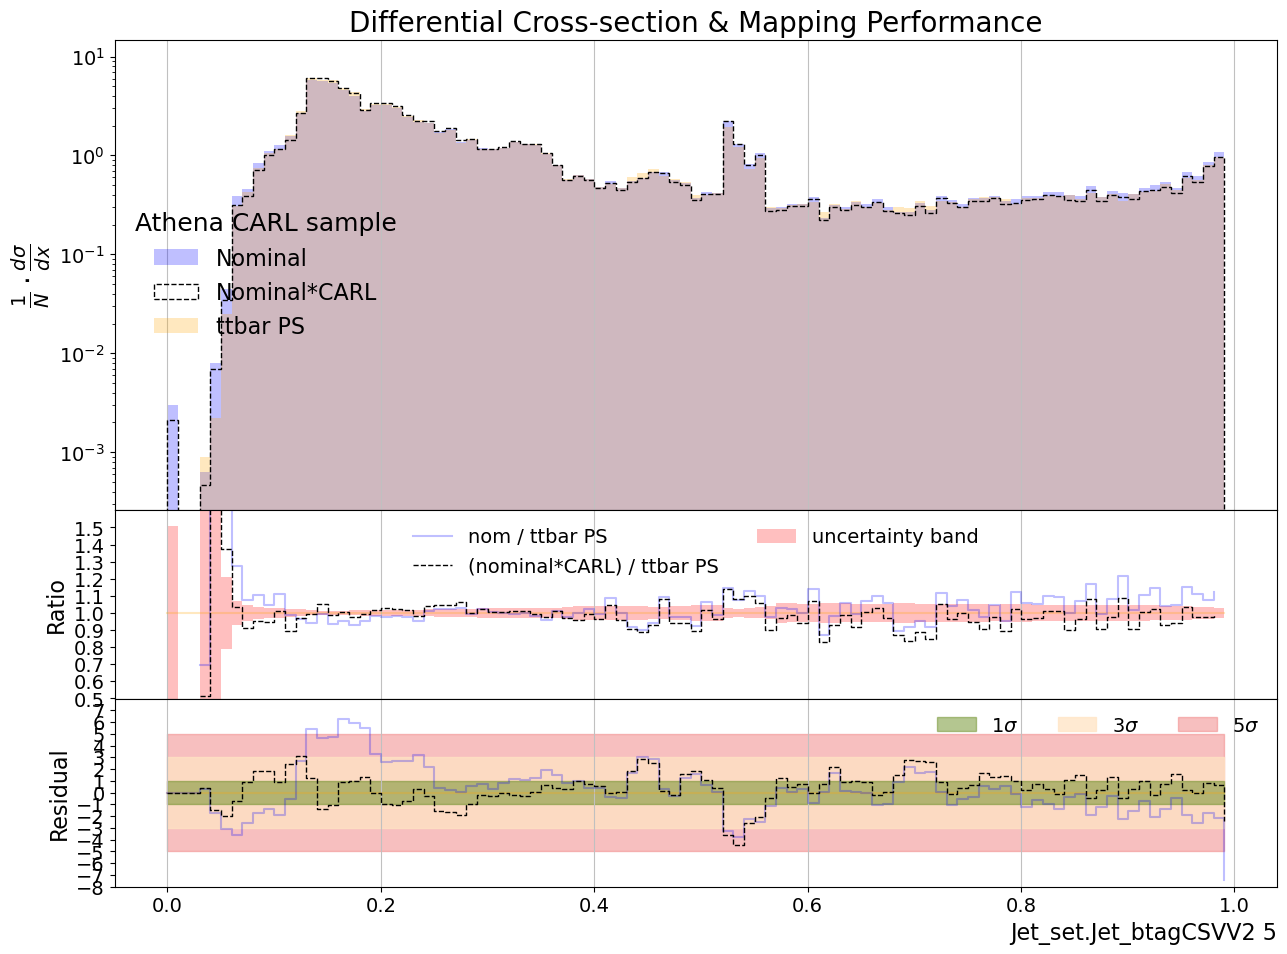

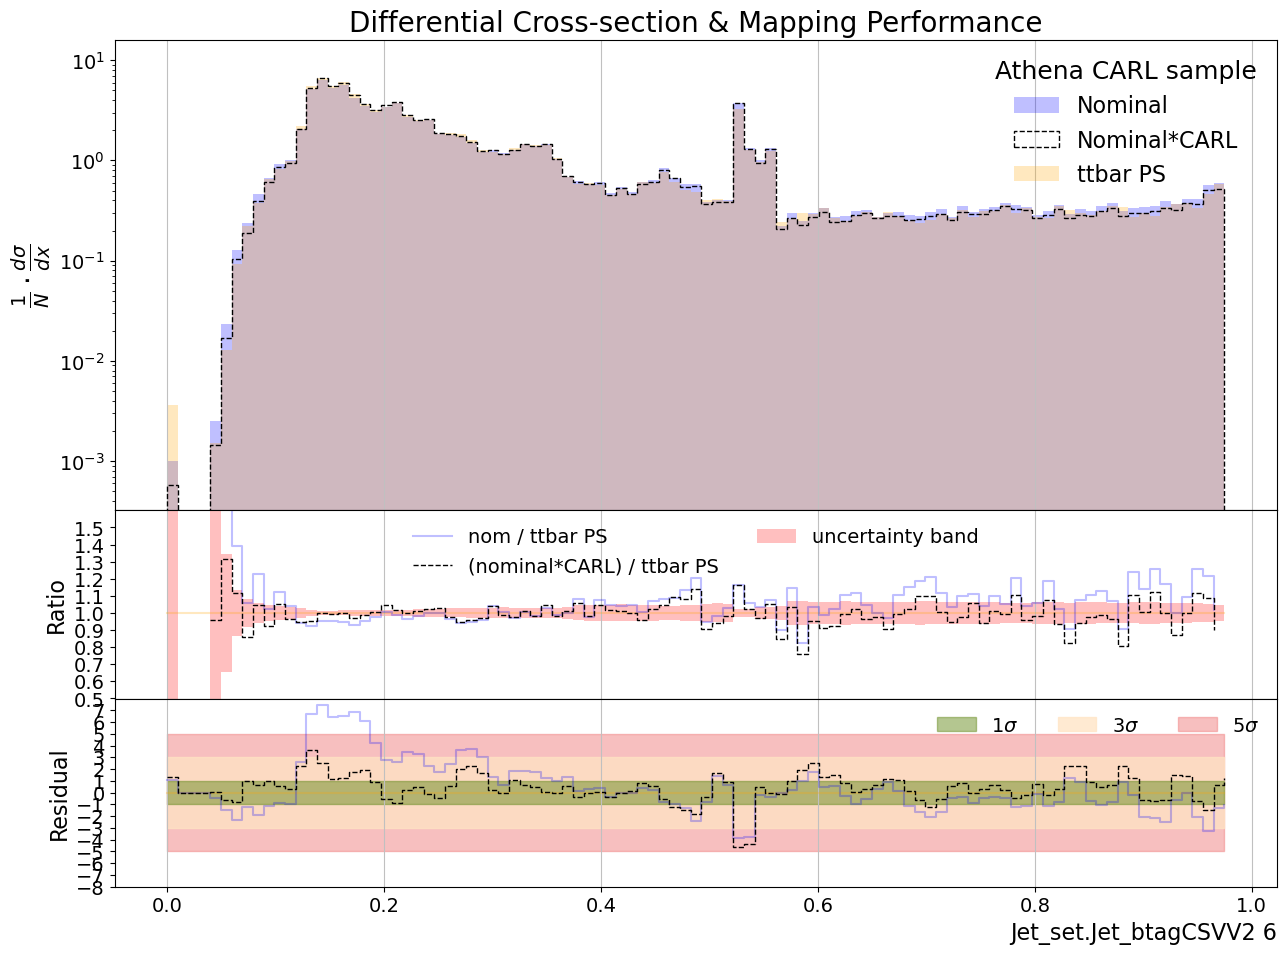

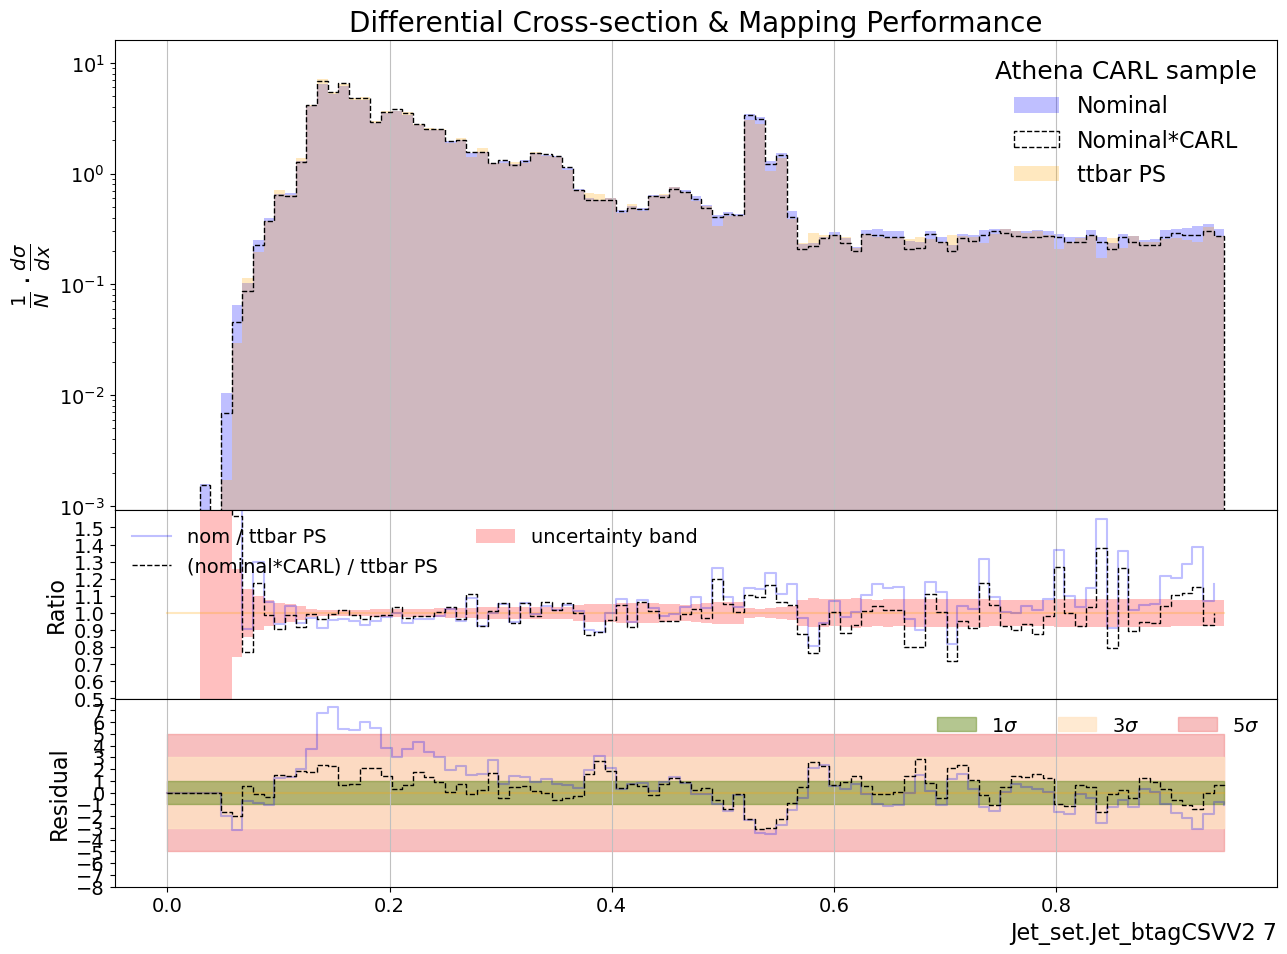

In [21]:
set_name = "Jet_set"
feature_name = "Jet_btagCSVV2"

for i in range(8):
    carl_plot.plot_carl_reweighting(test_nominal_generator_data, test_PS_var_generator_data, r_hats, features,
                                    set_name, index=i, subfeature_name=feature_name, sort_feature="Jet_pt",
                                    alternate_name="ttbar PS", nominal_mask=np.isfinite, alternate_mask=np.isfinite, saveAs="plots/{}_{}{}.png".format(set_name, feature_name, i))

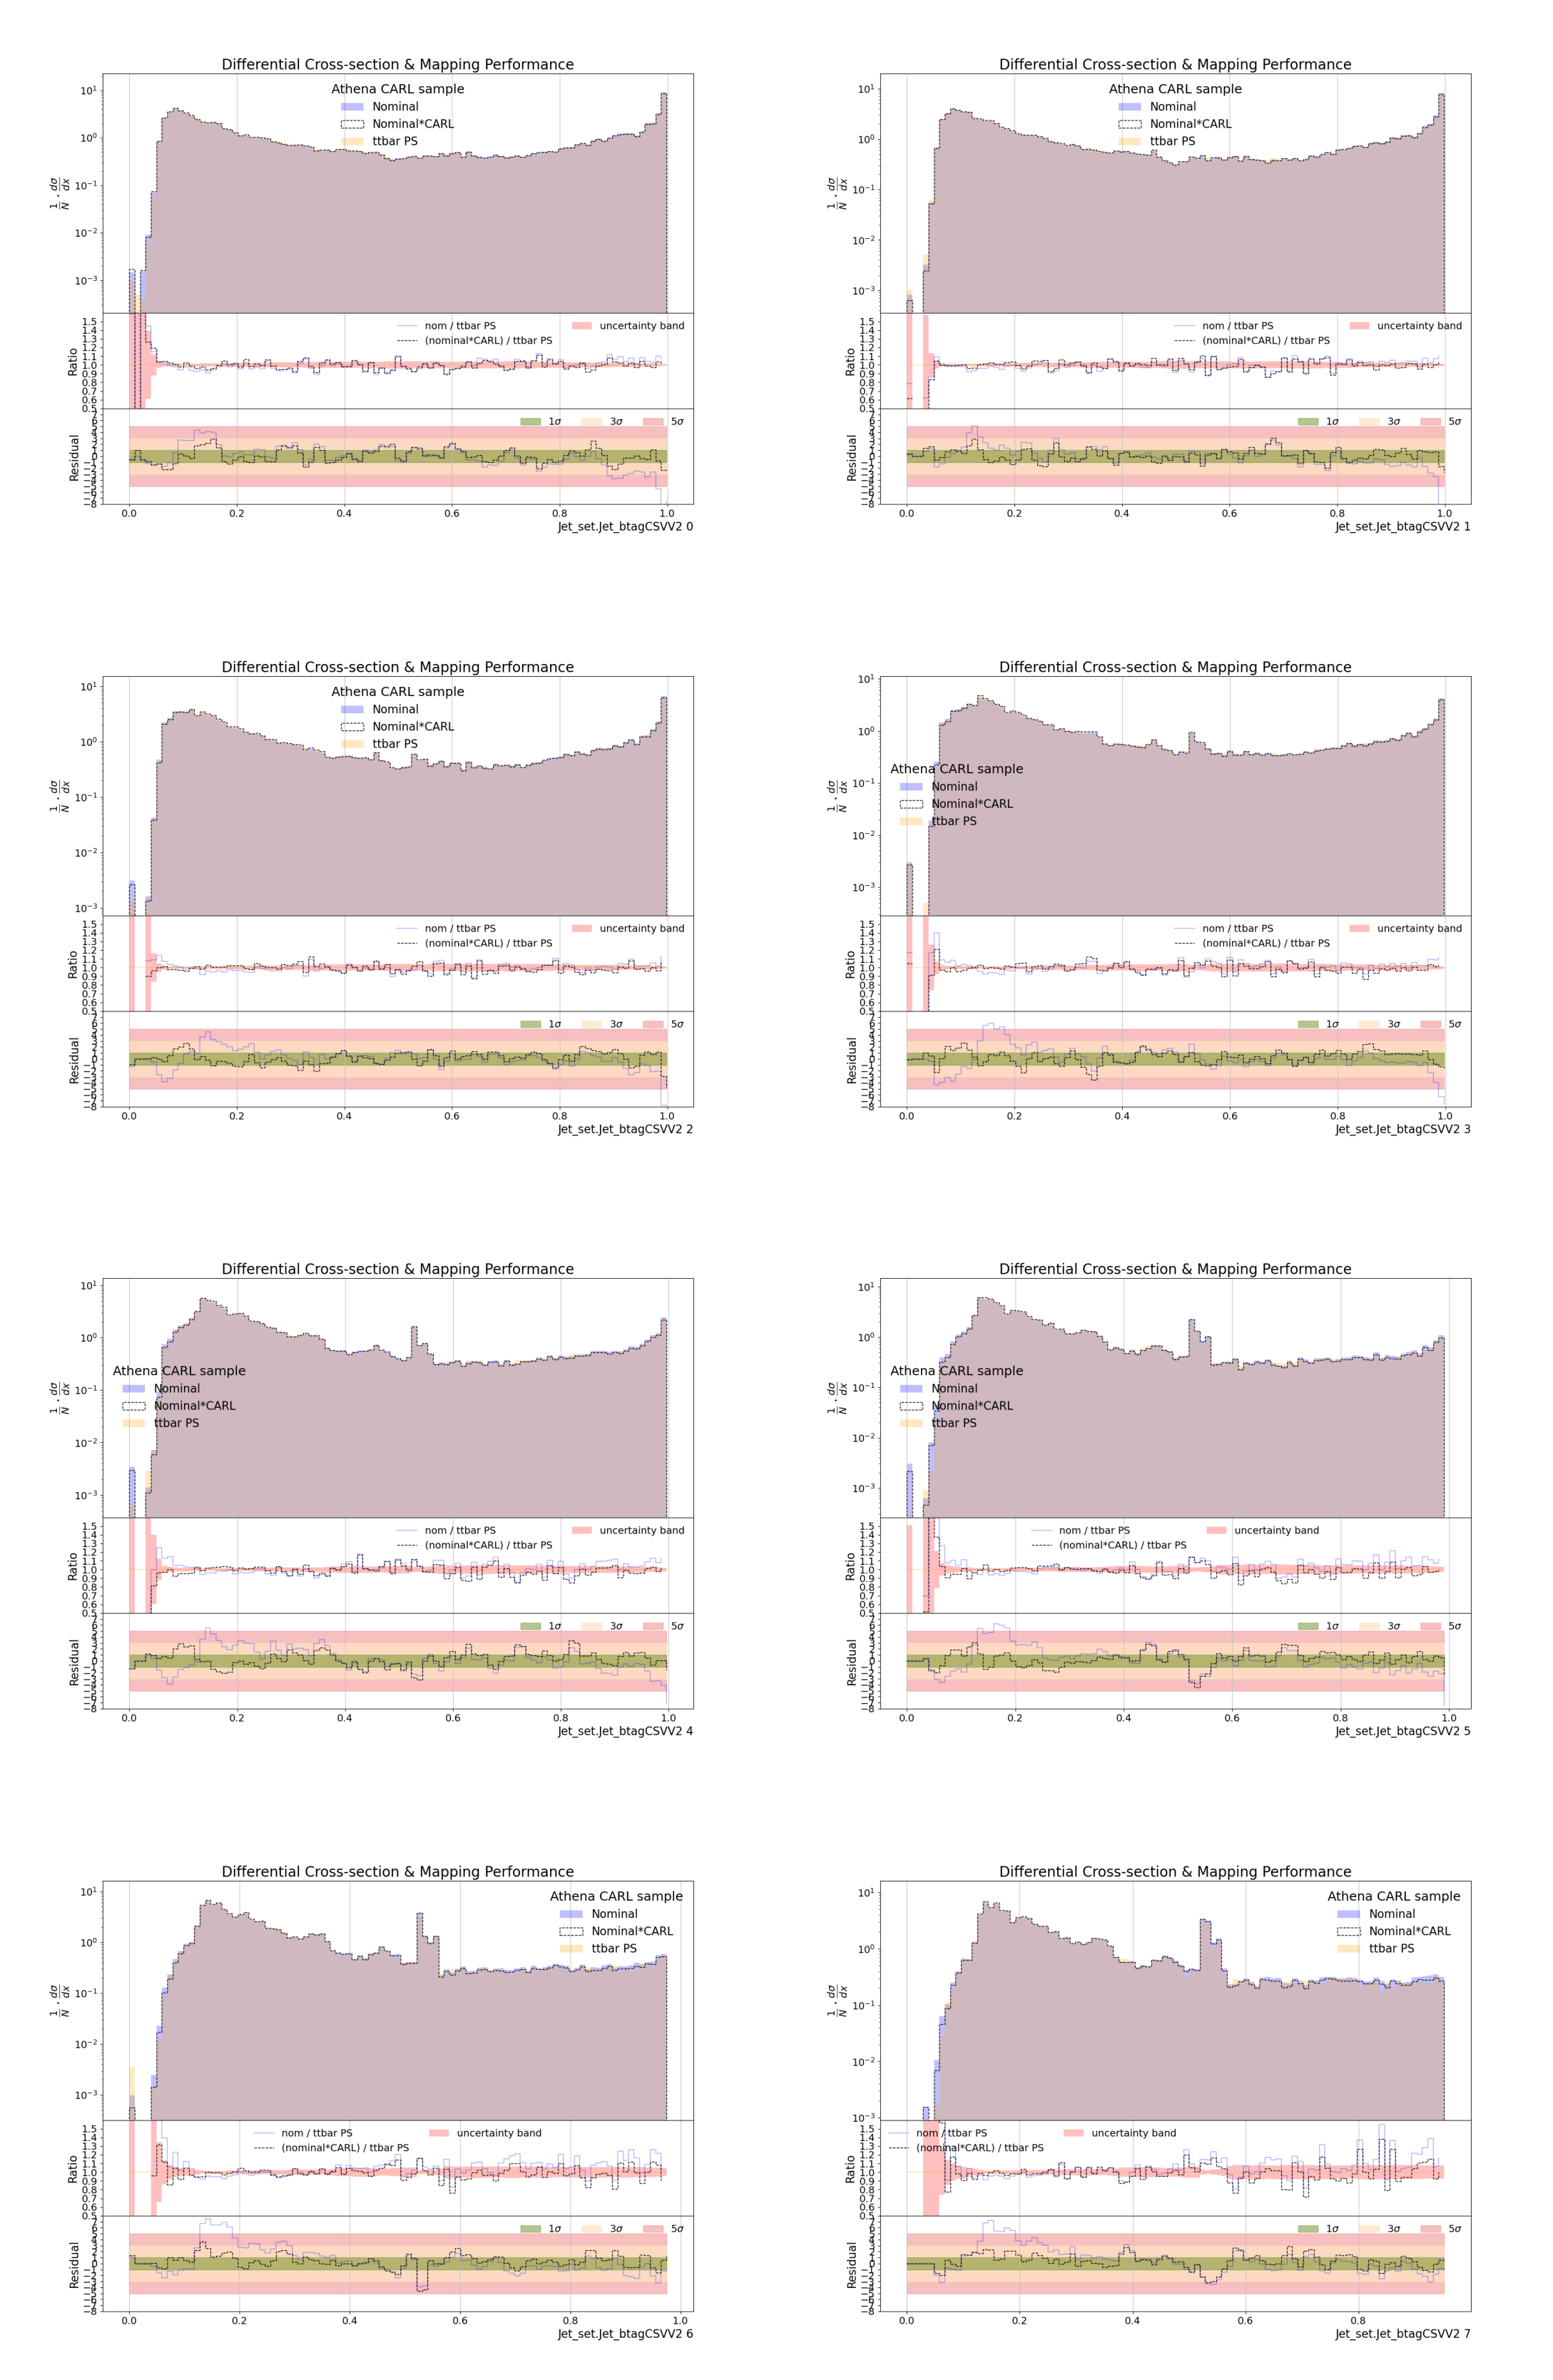

In [22]:
nrows = 4
ncolumns = 2

fig, axs = plt.subplots(nrows, ncolumns, figsize=(22,34))

set_name = "Jet_set"
feature_name = "Jet_btagCSVV2"

for i in range(nrows):
    for j in range(ncolumns):
        im = plt.imread("plots/{}_{}{}.png".format(set_name, feature_name, i*ncolumns + j))
        axs[i,j].imshow(im)
        axs[i,j].axis('off')
fig.tight_layout()

### Plot Muon features

In [ ]:
set_name = "Muon_set"
feature_name = "Muon_pt"

for i in range(4):
    carl_plot.plot_carl_reweighting(test_nominal_generator_data, test_PS_var_generator_data, r_hats, features,
                                    set_name, index=i, subfeature_name=feature_name, sort_feature="Muon_pt",
                                    alternate_name="ttbar PS", nominal_mask=np.isfinite, alternate_mask=np.isfinite, saveAs="plots/{}_{}{}.png".format(set_name, feature_name, i))

100%|██████████| 1563/1563 [01:16<00:00, 20.47it/s]


61223
59999


 69%|██████▉   | 1082/1563 [01:09<00:30, 15.55it/s]

In [ ]:
nrows = 2
ncolumns = 2

fig, axs = plt.subplots(nrows, ncolumns, figsize=(22,17))

set_name = "Muon_set"
feature_name = "Muon_pt"

for i in range(nrows):
    for j in range(ncolumns):
        im = plt.imread("plots/{}_{}{}.png".format(set_name, feature_name, i*ncolumns + j))
        axs[i,j].imshow(im)
        axs[i,j].axis('off')
fig.tight_layout()

In [ ]:
set_name = "Muon_set"
feature_name = "Muon_mass"

for i in range(4):
    carl_plot.plot_carl_reweighting(test_nominal_generator_data, test_PS_var_generator_data, r_hats, features,
                                    set_name, index=i, subfeature_name=feature_name, sort_feature="Muon_pt",
                                    alternate_name="ttbar PS", nominal_mask=np.isfinite, alternate_mask=np.isfinite, saveAs="plots/{}_{}{}.png".format(set_name, feature_name, i))

In [ ]:
nrows = 2
ncolumns = 2

fig, axs = plt.subplots(nrows, ncolumns, figsize=(22,17))

set_name = "Muon_set"
feature_name = "Muon_mass"

for i in range(nrows):
    for j in range(ncolumns):
        im = plt.imread("plots/{}_{}{}.png".format(set_name, feature_name, i*ncolumns + j))
        axs[i,j].imshow(im)
        axs[i,j].axis('off')
fig.tight_layout()

### Plot electron features

In [ ]:
set_name = "Electron_set"
feature_name = "Electron_pt"

for i in range(4):
    carl_plot.plot_carl_reweighting(test_nominal_generator_data, test_PS_var_generator_data, r_hats, features,
                                    set_name, index=i, subfeature_name=feature_name, sort_feature="Electron_pt",
                                    alternate_name="ttbar PS", nominal_mask=np.isfinite, alternate_mask=np.isfinite, saveAs="plots/{}_{}{}.png".format(set_name, feature_name, i))

In [ ]:
nrows = 2
ncolumns = 2

fig, axs = plt.subplots(nrows, ncolumns, figsize=(22,17))

set_name = "Electron_set"
feature_name = "Electron_pt"

for i in range(nrows):
    for j in range(ncolumns):
        im = plt.imread("plots/{}_{}{}.png".format(set_name, feature_name, i*ncolumns + j))
        axs[i,j].imshow(im)
        axs[i,j].axis('off')
fig.tight_layout()

In [ ]:
set_name = "Electron_set"
feature_name = "Electron_mass"

for i in range(4):
    carl_plot.plot_carl_reweighting(test_nominal_generator_data, test_PS_var_generator_data, r_hats, features,
                                    set_name, index=i, subfeature_name=feature_name, sort_feature="Electron_pt",
                                    alternate_name="ttbar PS", nominal_mask=np.isfinite, alternate_mask=np.isfinite, saveAs="plots/{}_{}{}.png".format(set_name, feature_name, i))

In [ ]:
nrows = 2
ncolumns = 2

fig, axs = plt.subplots(nrows, ncolumns, figsize=(22,17))

set_name = "Electron_set"
feature_name = "Electron_mass"

for i in range(nrows):
    for j in range(ncolumns):
        im = plt.imread("plots/{}_{}{}.png".format(set_name, feature_name, i*ncolumns + j))
        axs[i,j].imshow(im)
        axs[i,j].axis('off')
fig.tight_layout()

### Plot MET

100%|██████████| 782/782 [00:01<00:00, 479.49it/s]


100000
100000


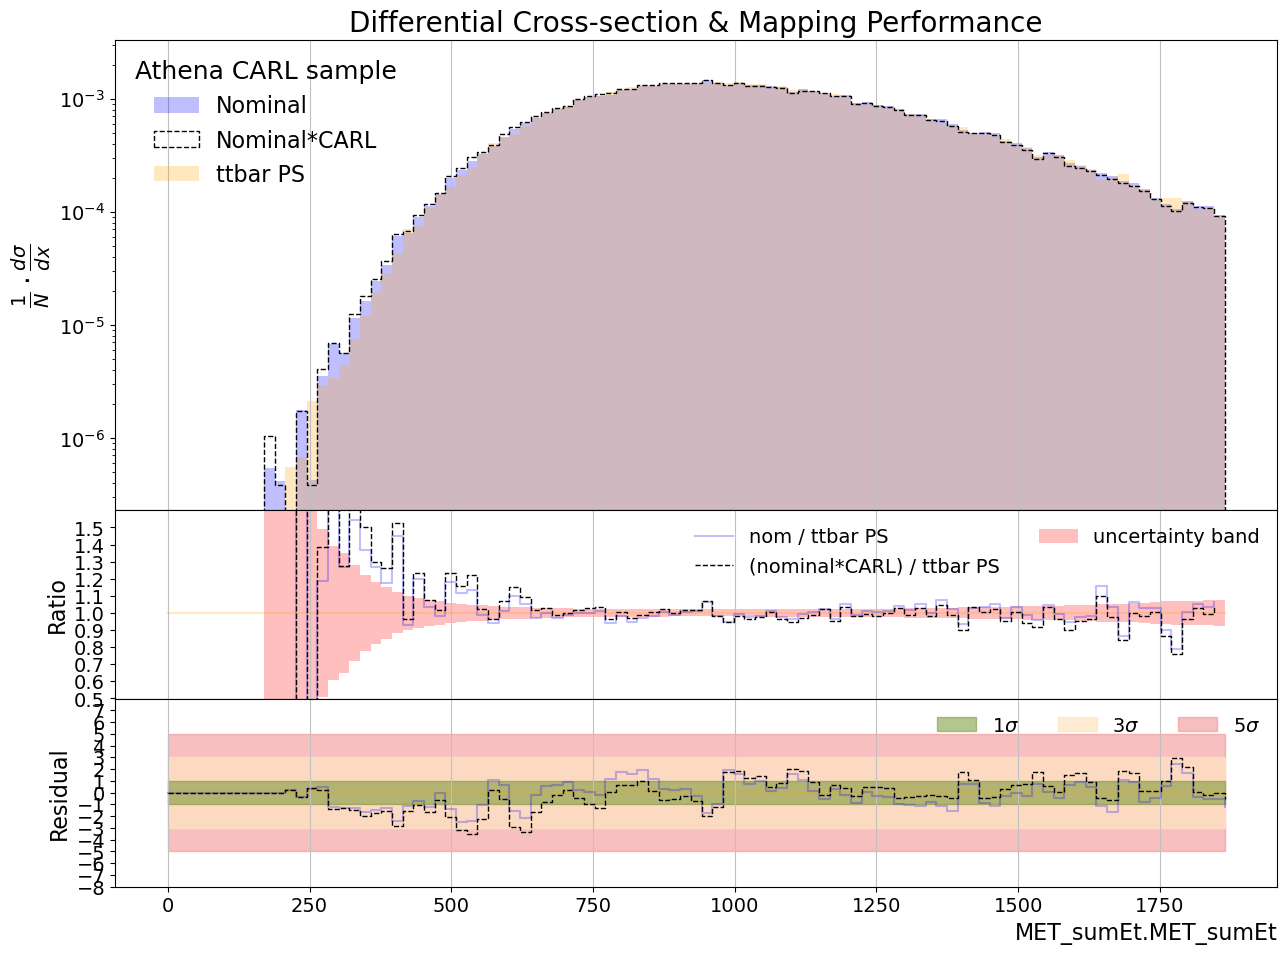

In [86]:
feature_name = "MET_sumEt"

carl_plot.plot_carl_reweighting(test_nominal_generator_data, test_PS_var_generator_data, r_hats, features,
                                feature_name, index=0,
                                alternate_name="ttbar PS", nominal_mask=np.isfinite, alternate_mask=np.isfinite, saveAs="plots/{}_{}{}.png".format(set_name, feature_name, i))

## Plot the reweighted distributions using the calibrated weights

100%|██████████| 1563/1563 [00:05<00:00, 273.06it/s]


199997
200000


100%|██████████| 1563/1563 [00:05<00:00, 279.71it/s]


199981
199993


/home/mdrnevich/AGC/carl-for-agc/carl_utils/plotting.py:198: RuntimeWarning: divide by zero encountered in divide
  carl_ratio = carl_hist/x1_hist
100%|██████████| 1563/1563 [00:06<00:00, 259.70it/s]


199760
199833


100%|██████████| 1563/1563 [00:06<00:00, 233.29it/s]


197917
198498


100%|██████████| 1563/1563 [00:09<00:00, 158.96it/s]


190027
192492


100%|██████████| 1563/1563 [00:18<00:00, 83.08it/s]


170290
176687


100%|██████████| 1563/1563 [00:33<00:00, 46.23it/s]


138637
149370


100%|██████████| 1563/1563 [00:52<00:00, 29.87it/s]


101995
114905


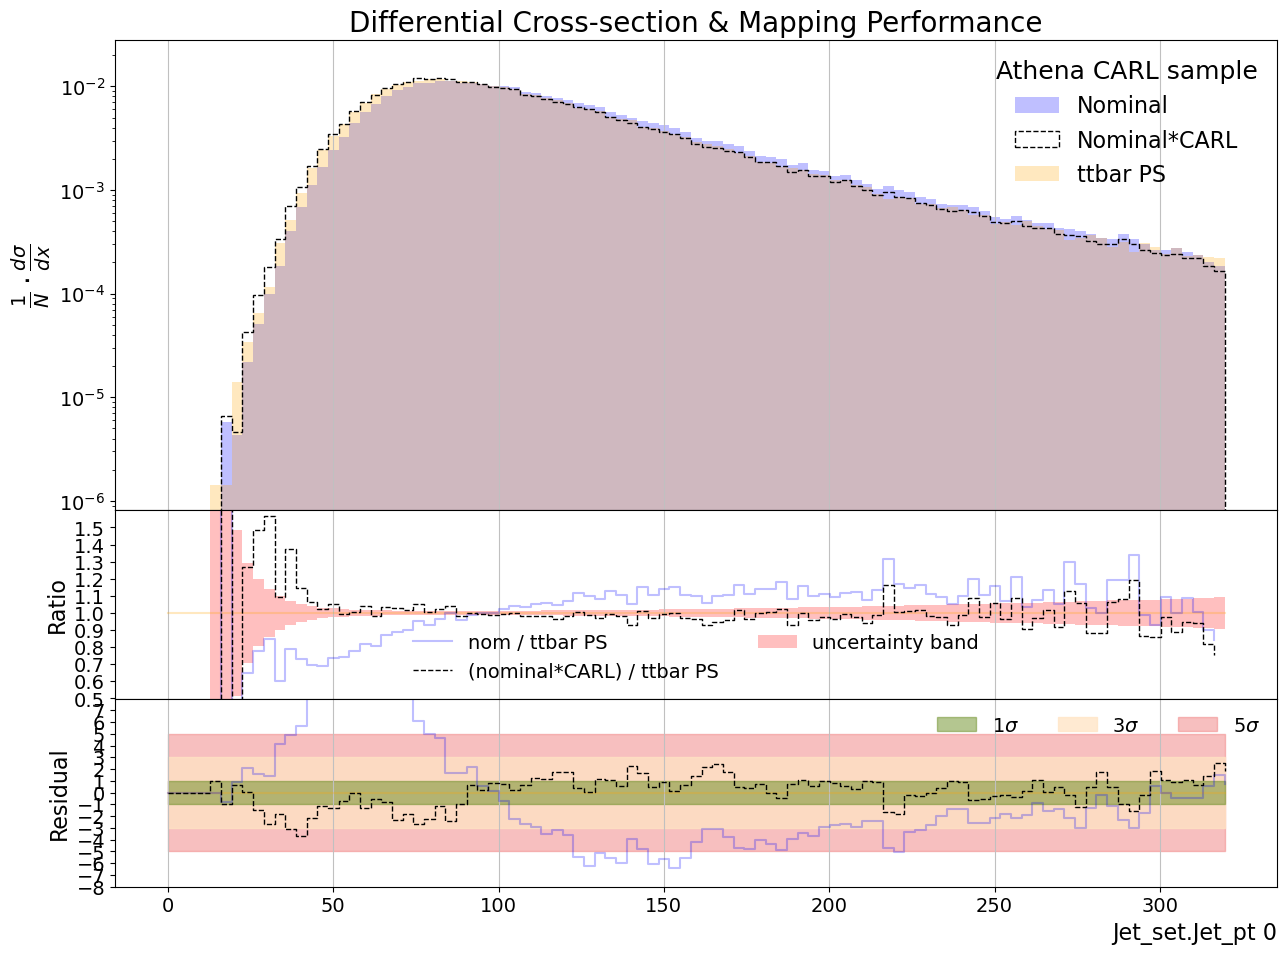

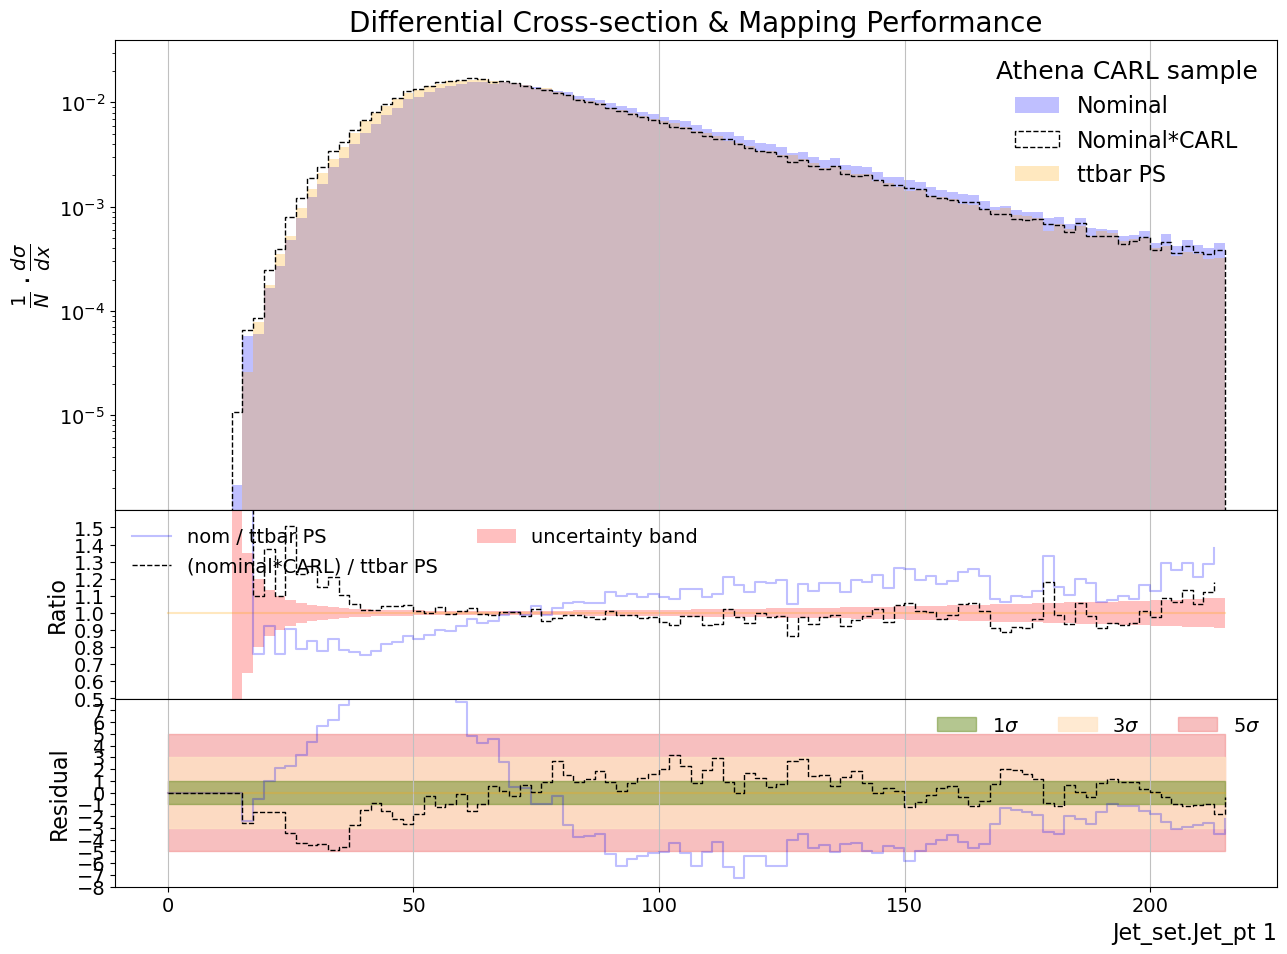

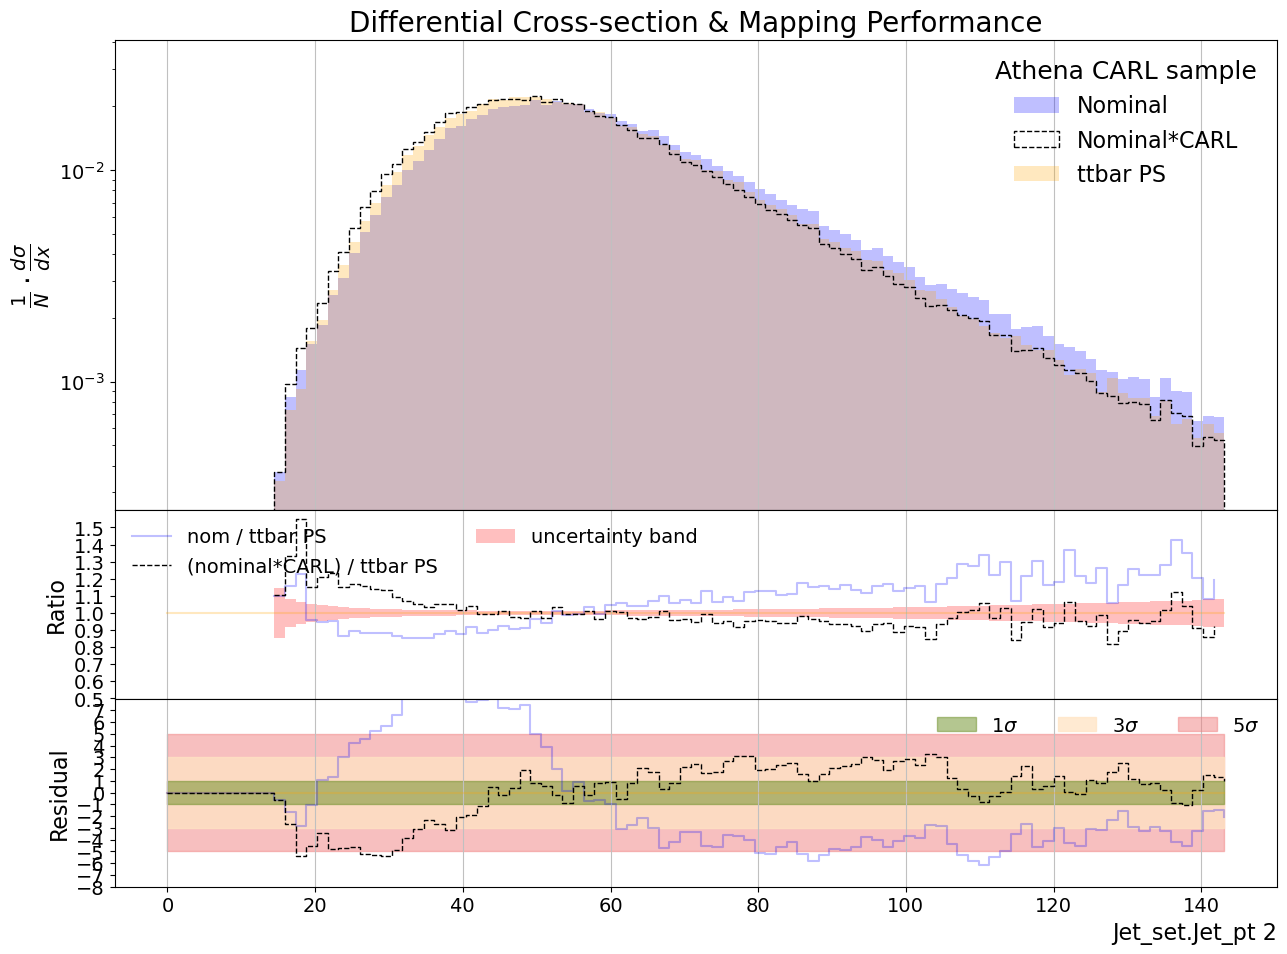

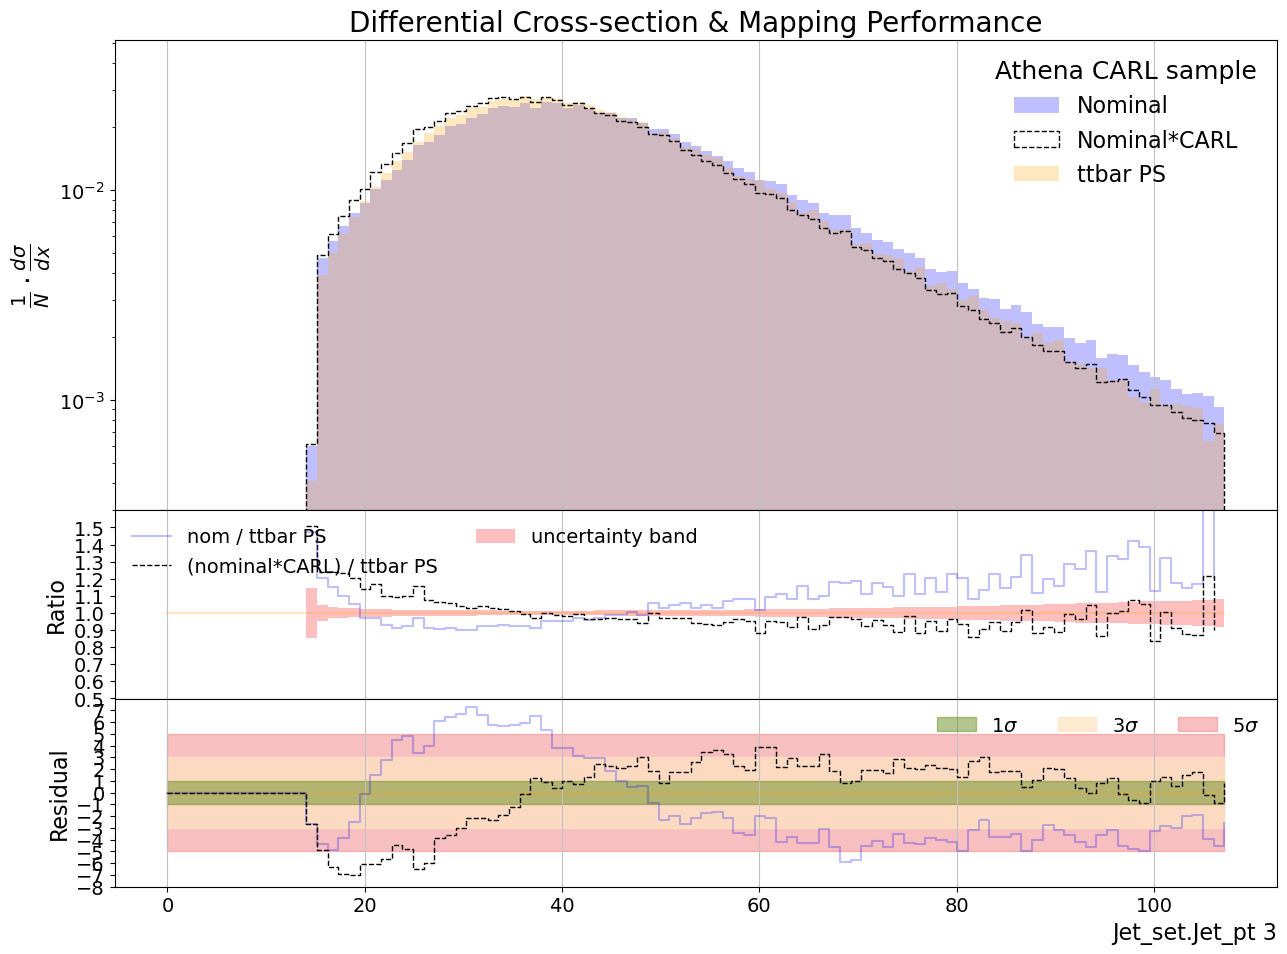

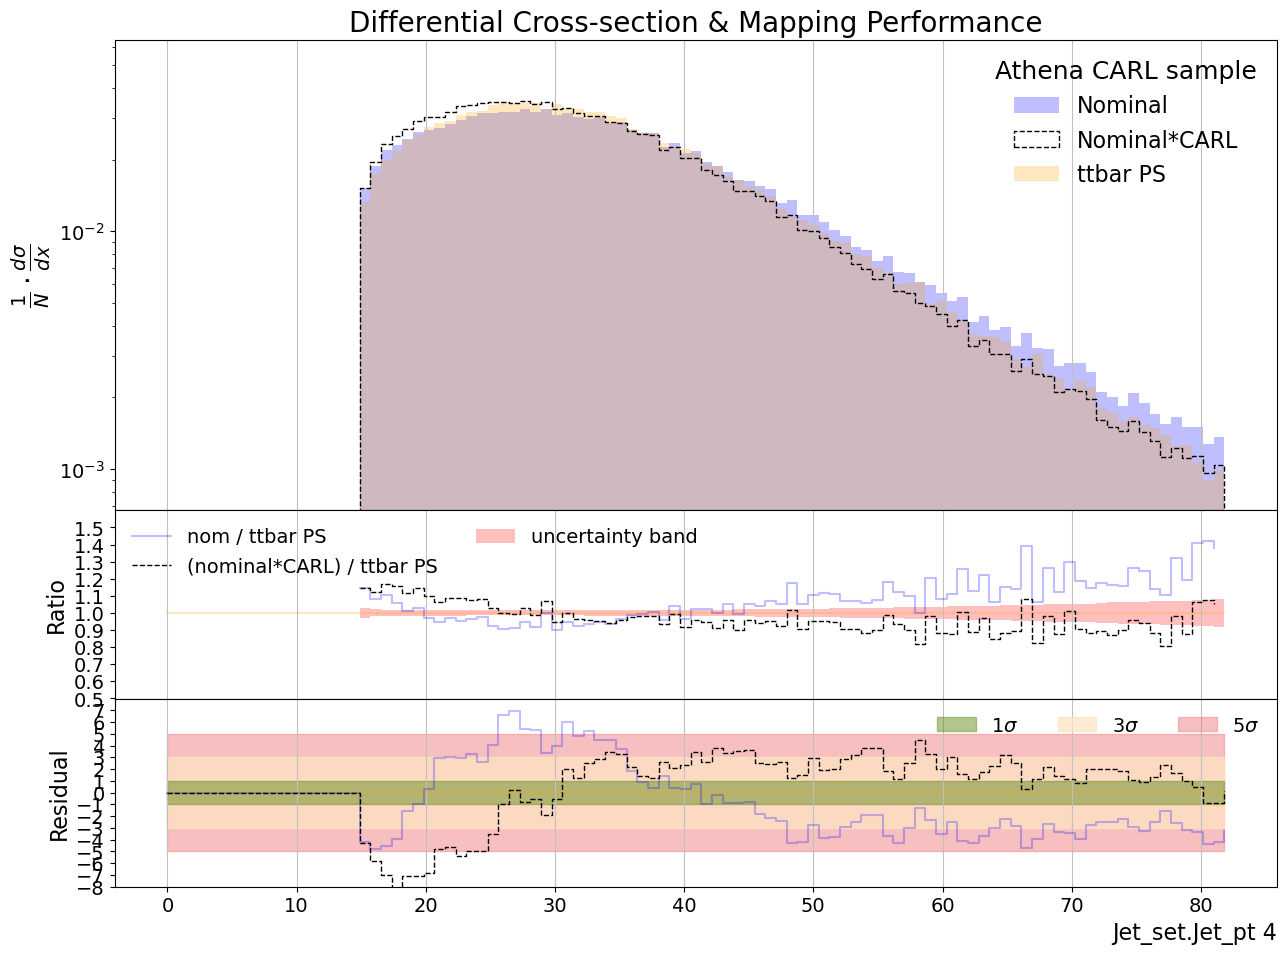

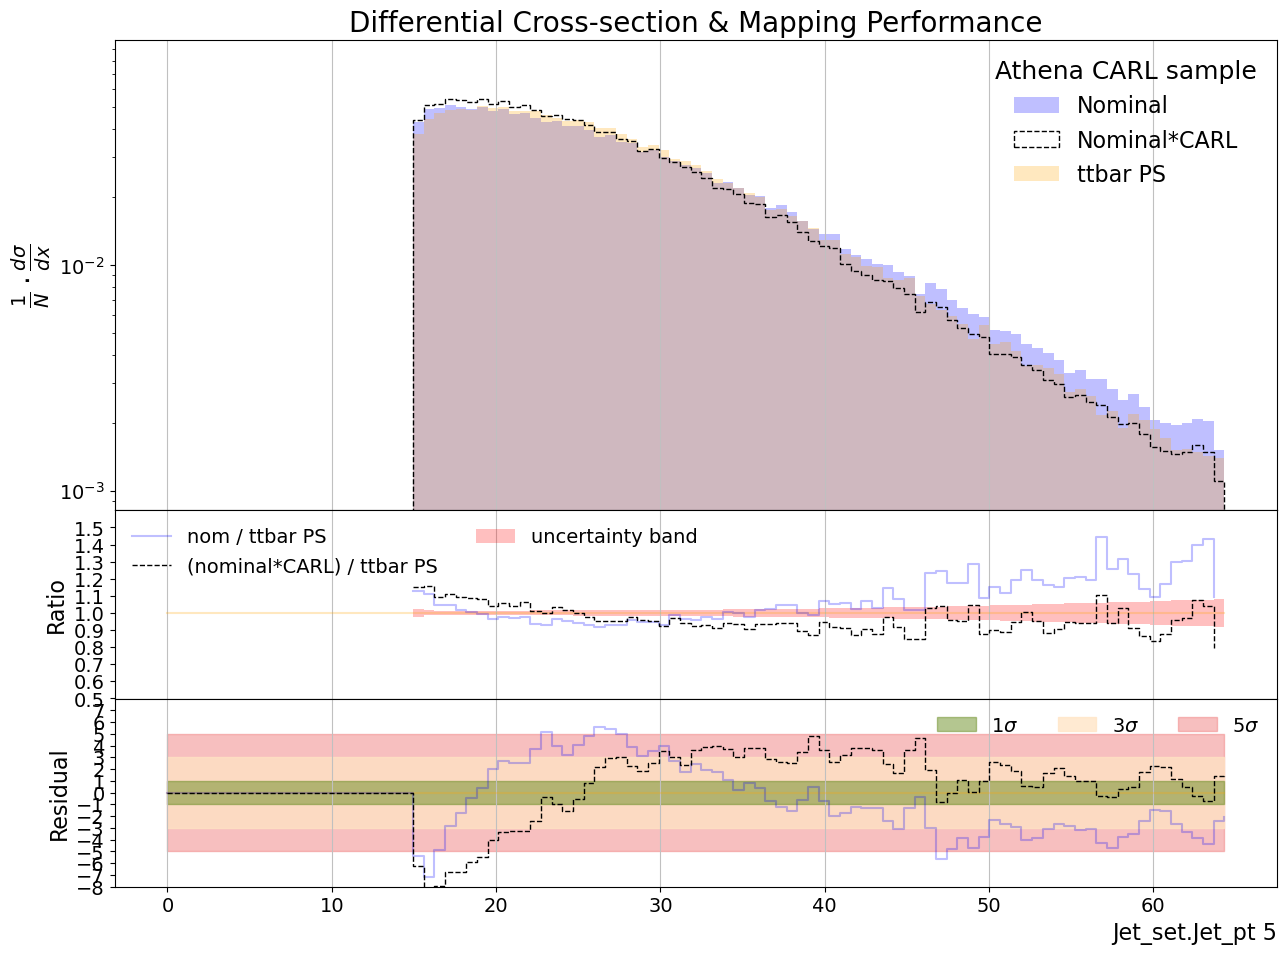

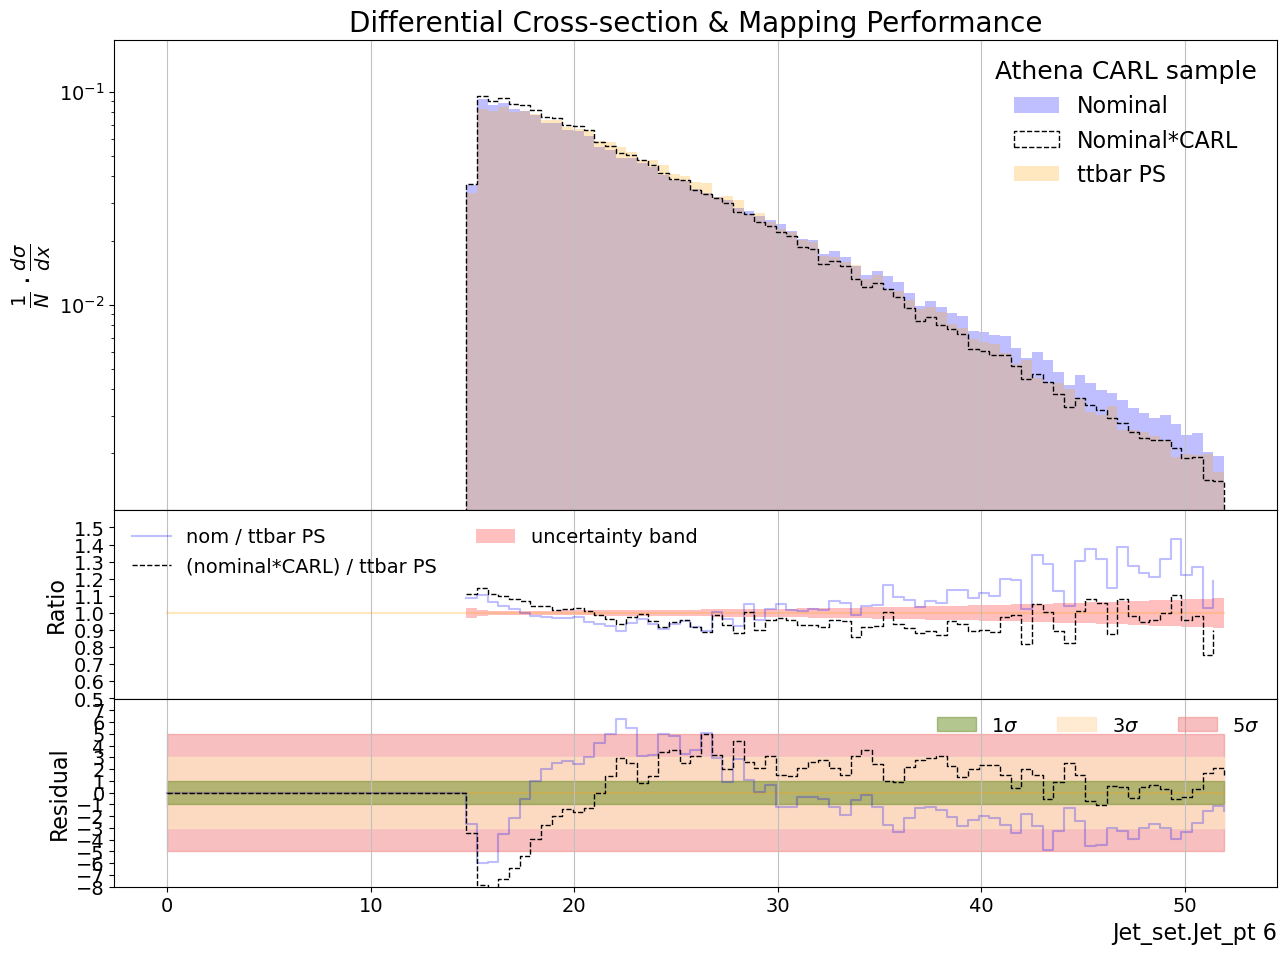

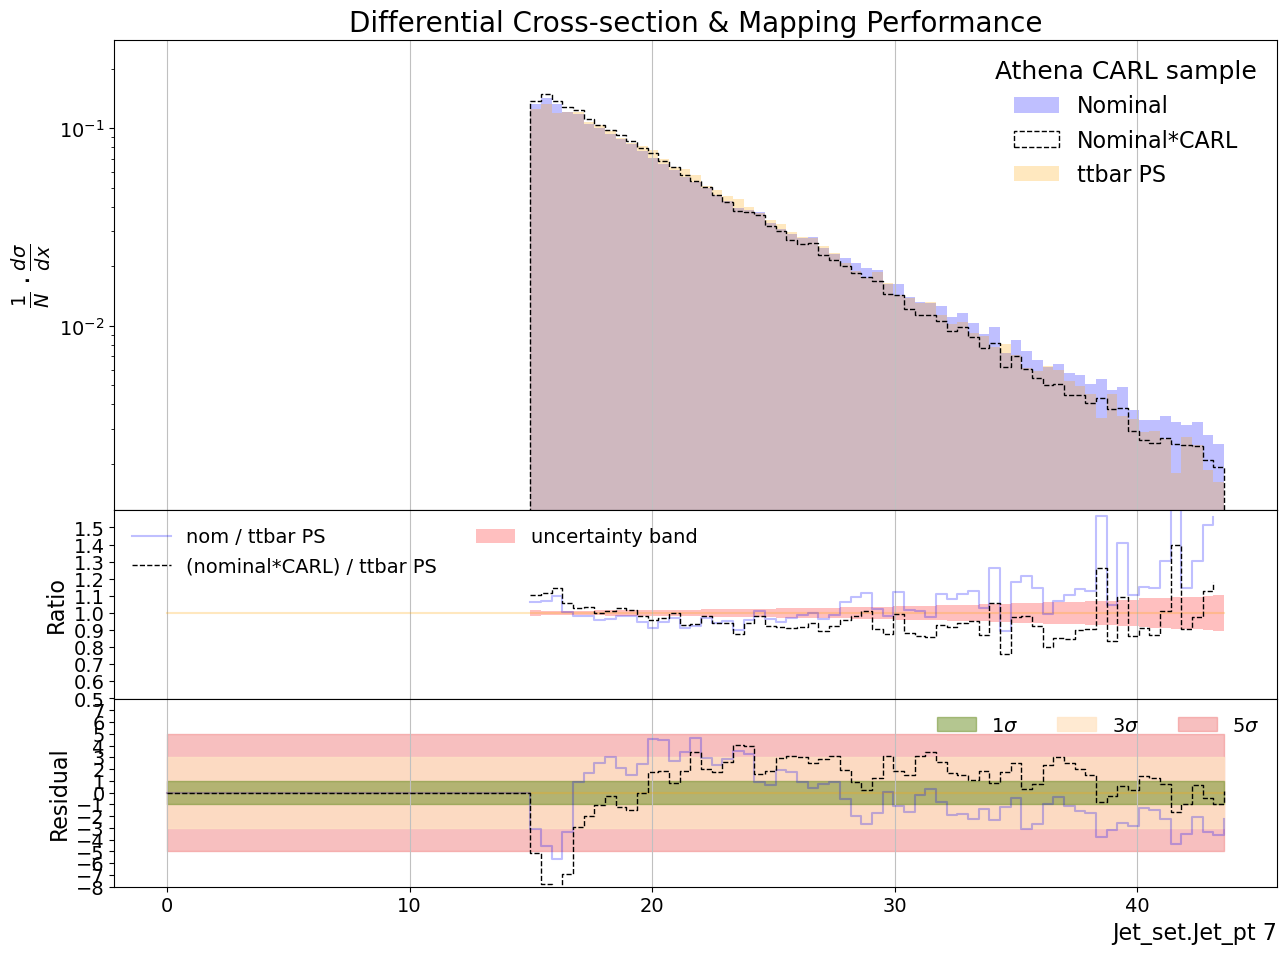

In [35]:
set_name = "Jet_set"
feature_name = "Jet_pt"

for i in range(8):
    carl_plot.plot_carl_reweighting(test_nominal_generator_data, test_PS_var_generator_data, calibrated_r_hats, features,
                                    set_name, index=i, subfeature_name=feature_name, sort_feature="Jet_pt",
                                    alternate_name="ttbar PS", nominal_mask=np.isfinite, carl_mask=np.isfinite, alternate_mask=np.isfinite, saveAs="plots/{}_{}{}.png".format(set_name, feature_name, i))

## Calibration doesn't seem to help in this case